In [ ]:
!pip install fredapi requests yahoo_fin bs4 tabulate openai==0.28 anthropic google-generativeai rouge_score ace_tools
#!pip install llama_cpp_python

import yfinance as yf
import pandas as pd
import random
from fredapi import Fred
import requests
from yahoo_fin import news
from bs4 import BeautifulSoup
from tabulate import tabulate
import random
import openai
import anthropic
#from llama_cpp import Llama
import google.generativeai as genai
import re
import random
import nltk
import pandas as pd
from yahoo_fin import news
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

#NOTE TO SELF - for testing am just training on 2021 data, and evaluation on 2022 - NEED TO CHANGE for actual data
#To change - Time period for training data, time period for evaluation data, list of tickers
#Add meta llama or gemini as well
#To uncomment - time values for all LLMs; the number of values and number of non-NONE values for each LLM
#Possibly add - a feature that compares LLMs predictions for more specific things - e.g, equity types, time periods

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=acf0ba8b21a702ae25723d3ca494d057b11dabd7e17f968062d745b3b144f684
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
  Created wheel f

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#preprocessing training data for financial news articles
nltk_resources = ["punkt", "stopwords", "wordnet"]

for resource in nltk_resources:
    try:
        nltk.data.find(f"tokenizers/{resource}")
    except LookupError:
        print(f"🔹 Downloading missing NLTK resource: {resource}")
        nltk.download(resource)


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

import re
import random
import nltk
import pandas as pd
from yahoo_fin import news
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# 🔹 Download necessary NLTK resources (only needed once)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# 🔹 Initialize NLP components
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# 🔹 List of S&P 500 stock tickers (expandable)
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]

# 🔹 Function to generate a random date between 2011 and 2021
def random_date():
    start_date = datetime(2011, 1, 1)
    end_date = datetime(2021, 12, 31)
    return start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

# 🔹 Function to clean and preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return " ".join(words)

# 🔹 Fetch and process financial news for at least 100 random ticker-date pairs
news_data = []
attempts = 0

while len(news_data) < 500 and attempts < 2000:
    attempts += 1
    ticker = random.choice(sp500_tickers_test)
    date = random_date().strftime('%Y-%m-%d')

    try:

        latest_news = news.get_yf_rss(ticker)

        if latest_news:
            for article in latest_news[:1]:
                title = article["title"]
                link = article["link"]
                cleaned_title = clean_text(title)

                news_data.append({
                    "Ticker": ticker,
                    "Date": date,
                    "Original Title": title,
                    "Cleaned Title": cleaned_title,
                    "Link": link
                })

    except Exception as e:
        print(f"⚠️ Error fetching news for {ticker} on {date}: {e}")

df_news = pd.DataFrame(news_data)

import tabulate
print("\n📊 Processed Historical Financial News:\n")
print(tabulate.tabulate(df_news.head(100), headers="keys", tablefmt="fancy_grid"))

df_news.to_csv("historical_financial_news.csv", index=False)
print("Processed financial news saved to 'historical_financial_news.csv'")

🔹 Downloading missing NLTK resource: stopwords
🔹 Downloading missing NLTK resource: wordnet


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



📊 Processed Historical Financial News:

╒════╤══════════╤════════════╤═══════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Ticker   │ Date       │ Original Title                                                    │ Cleaned Title                                                  │ Link                                                                                                                                                                                                                   │
╞════╪══════════╪════════════╪═══════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════╪══════════════════════════════════

In [ ]:
#Pre-Processing Training Numerical data
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "T", "UNH", "MRK", "MMM", "LMT",
    "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT", "NKE", "CVX", "TMO",
    "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET", "BK", "TGT", "BLK",
    "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI", "ISRG", "ZTS", "PLD",
    "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX", "EL", "FDX", "EMR",
    "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG", "CTSH", "DHR", "NSC",
    "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD", "AFL", "OXY", "VLO",
    "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]

sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]

# 🔹 Define financial features to extract
financial_features = ["Open", "High", "Low", "Close", "Volume"]

# 🔹 Time range (matching news dataset: 2011-2021)
start_date = "2011-01-01"
end_date = "2021-12-31"

# 🔹 Dictionary to store financial data
financial_data = []

# 🔹 Fetch data for each ticker
for ticker in sp500_tickers:
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        if not df.empty:
            df.reset_index(inplace=True)  # Ensure 'Date' is a column
            df["Ticker"] = ticker  # Add ticker column

            # 🔹 Ensure "Adj Close" is available, else use "Close"
            if "Adj Close" in df.columns:
                df["Adj Close"] = df["Adj Close"]
            else:
                df["Adj Close"] = df["Close"]  # Use Close if Adj Close is missing

            # 🔹 Select relevant columns
            df = df[["Date", "Ticker"] + financial_features + ["Adj Close"]]

            financial_data.append(df)

    except Exception as e:
        print(f"⚠️ Error fetching data for {ticker}: {e}")

# 🔹 Combine data into a single DataFrame
df_financials = pd.concat(financial_data, ignore_index=True)

# ✅ Step 1: Handle Missing Values
df_financials.dropna(inplace=True)  # Remove rows with missing values

# ✅ Step 2: Convert Date Column to Datetime
df_financials["Date"] = pd.to_datetime(df_financials["Date"])

# ✅ Step 3: Remove Outliers (Using IQR Method)
for column in ["Open", "High", "Low", "Close", "Adj Close"]:
    Q1 = df_financials[column].quantile(0.25)
    Q3 = df_financials[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_financials = df_financials[(df_financials[column] >= lower_bound) & (df_financials[column] <= upper_bound)]

# ✅ Step 4: Normalize Numerical Features (Min-Max Scaling)
for column in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    df_financials[column] = (df_financials[column] - df_financials[column].min()) / (df_financials[column].max() - df_financials[column].min())

# ✅ Save Cleaned Numerical Financial Data to CSV
df_financials.to_csv("financial_forecasting_cleaned.csv", index=False)
print("\n✅ Cleaned financial forecasting data saved to 'financial_forecasting_cleaned.csv'")

df_financials2 = pd.read_csv("financial_forecasting_cleaned.csv")

# 🔹 Display the first few rows using tabulate
print("\n📊 Cleaned Financial Forecasting Data (2011-2021):\n")
print(tabulate.tabulate(df_financials.head(20), headers="keys", tablefmt="fancy_grid"))

ERROR:yfinance:$FB: possibly delisted; no timezone found



✅ Cleaned financial forecasting data saved to 'financial_forecasting_cleaned.csv'

📊 Cleaned Financial Forecasting Data (2011-2021):

╒════╤═══════════════════════════╤══════════╤═══════════╤═══════════╤═══════════╤═════════════╤══════════╤═════════════╕
│    │ Date                      │ Ticker   │      Open │      High │       Low │       Close │   Volume │   Adj Close │
╞════╪═══════════════════════════╪══════════╪═══════════╪═══════════╪═══════════╪═════════════╪══════════╪═════════════╡
│  0 │ 2021-12-21 00:00:00-05:00 │ AAPL     │ 0.379677  │ 0.379862  │ 0.365417  │ 0.388835    │ 0.989322 │ 0.388835    │
├────┼───────────────────────────┼──────────┼───────────┼───────────┼───────────┼─────────────┼──────────┼─────────────┤
│  1 │ 2021-12-22 00:00:00-05:00 │ AAPL     │ 0.399957  │ 0.416591  │ 0.406671  │ 0.426005    │ 1        │ 0.426005    │
├────┼───────────────────────────┼──────────┼───────────┼───────────┼───────────┼─────────────┼──────────┼─────────────┤
│  2 │ 2021-12-23 

In [ ]:
#PreProcessing Evaluation Numerical Data
# 🔹 Define test tickers (subset of S&P 500)
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]

# 🔹 Time range for data collection (2022)
start_date = "2022-01-01"
end_date = "2024-12-31"

# 🔹 List to store financial data
financial_data = []

# 🔹 Fetch data for each ticker
for ticker in sp500_tickers:
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        if not df.empty:
            df.reset_index(inplace=True)  # Ensure 'Date' is a column
            df["Ticker"] = ticker  # Add ticker column

            # 🔹 Use "Adj Close" if available, else default to "Close"
            if "Adj Close" not in df.columns:
                df["Adj Close"] = df["Close"]

            # 🔹 Convert Date to YYYY-MM-DD format
            df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")

            # 🔹 Select relevant columns (Ticker, Date, Adjusted Close Price)
            df = df[["Ticker", "Date", "Adj Close"]]

            financial_data.append(df)

    except Exception as e:
        print(f"⚠️ Error fetching data for {ticker}: {e}")

# 🔹 Combine data into a single DataFrame
df_financials = pd.concat(financial_data, ignore_index=True)

# ✅ Step 1: Handle Missing Values
df_financials.dropna(inplace=True)  # Remove rows with missing values

# ✅ Save Cleaned Financial Data to CSV (only Ticker, Date, Adj Close)
csv_path = "financial_forecasting_cleaned_two.csv"
df_financials.to_csv(csv_path, index=False)
print(f"\n✅ Cleaned financial forecasting data saved to '{csv_path}'")

# 🔹 Display first few rows
print("\n📊 Cleaned Financial Forecasting Data:\n")
print(tabulate.tabulate(df_financials.head(20), headers="keys", tablefmt="fancy_grid"))

ERROR:yfinance:$FB: possibly delisted; no timezone found



✅ Cleaned financial forecasting data saved to 'financial_forecasting_cleaned_two.csv'

📊 Cleaned Financial Forecasting Data:

╒════╤══════════╤════════════╤═════════════╕
│    │ Ticker   │ Date       │   Adj Close │
╞════╪══════════╪════════════╪═════════════╡
│  0 │ AAPL     │ 2022-01-03 │    178.88   │
├────┼──────────┼────────────┼─────────────┤
│  1 │ AAPL     │ 2022-01-04 │    176.61   │
├────┼──────────┼────────────┼─────────────┤
│  2 │ MSFT     │ 2022-01-03 │    325.635  │
├────┼──────────┼────────────┼─────────────┤
│  3 │ MSFT     │ 2022-01-04 │    320.051  │
├────┼──────────┼────────────┼─────────────┤
│  4 │ GOOGL    │ 2022-01-03 │    144.302  │
├────┼──────────┼────────────┼─────────────┤
│  5 │ GOOGL    │ 2022-01-04 │    143.712  │
├────┼──────────┼────────────┼─────────────┤
│  6 │ AMZN     │ 2022-01-03 │    170.404  │
├────┼──────────┼────────────┼─────────────┤
│  7 │ AMZN     │ 2022-01-04 │    167.522  │
├────┼──────────┼────────────┼─────────────┤
│  8 │ TSLA     │ 

In [ ]:
#Sorting numerical and textual data based on ticker
import pandas as pd
from tabulate import tabulate

# 🔹 Load financial news dataset (Experiment 1)
df_news = pd.read_csv("historical_financial_news.csv")

# 🔹 Load numerical financial data (Experiment 2)
df_financials = pd.read_csv("financial_forecasting_cleaned.csv")
df_financials2 = pd.read_csv("financial_forecasting_cleaned_two.csv")

# 🔹 Convert Date column to datetime format in both datasets
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_financials2["Date"] = pd.to_datetime(df_financials2["Date"])
# 🔹 Sort each dataset by Ticker and Date
df_news_sorted = df_news.sort_values(by=["Ticker", "Date"])
df_financials_sorted = df_financials.sort_values(by=["Ticker", "Date"])
df_financials2_sorted = df_financials2.sort_values(by=["Ticker", "Date"])
# ✅ Save sorted datasets to separate CSVs
df_news_sorted.to_csv("sorted_financial_news.csv", index=False)
df_financials_sorted.to_csv("sorted_financial_numerical_data.csv", index=False)
df_financials_sorted.to_csv("sorted_financial_numerical_data_two.csv", index=False)

print("\n✅ Financial news sorted by Ticker and Date saved as 'sorted_financial_news.csv'")
print("✅ Numerical financial data sorted by Ticker and Date saved as 'sorted_financial_numerical_data.csv'")

# 📊 Display first few rows of each dataset
print("\n📊 Sorted Financial News Data:\n")
print(tabulate(df_news_sorted.head(20), headers="keys", tablefmt="fancy_grid"))

print("\n📊 Sorted Numerical Financial Data:\n")
print(tabulate(df_financials_sorted.head(20), headers="keys", tablefmt="fancy_grid"))


✅ Financial news sorted by Ticker and Date saved as 'sorted_financial_news.csv'
✅ Numerical financial data sorted by Ticker and Date saved as 'sorted_financial_numerical_data.csv'

📊 Sorted Financial News Data:

╒════╤══════════╤═════════════════════╤═══════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Ticker   │ Date                │ Original Title                                                    │ Cleaned Title                                                  │ Link                                                                                                                                                                                                                   │
╞════╪═

In [ ]:
#Time series alignment of numerical and textual data simultaneously

# 🔹 Load the sorted numerical financial data
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")

# 🔹 Load the sorted financial news data
df_news = pd.read_csv("sorted_financial_news.csv")

# 🔹 Convert Date column to datetime format in both datasets
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_news["Date"] = pd.to_datetime(df_news["Date"])

# 🔹 Create a list to store ordered rows (numerical data followed by news articles)
merged_data = []

# 🔹 Iterate through each unique ticker
for ticker in df_financials["Ticker"].unique():
    # 🔹 Filter financial and news data for the current ticker
    financial_subset = df_financials[df_financials["Ticker"] == ticker]
    news_subset = df_news[df_news["Ticker"] == ticker]

    # 🔹 Iterate through each row in financial data
    for _, fin_row in financial_subset.iterrows():
        merged_data.append(fin_row.to_dict())  # Append financial row first

        # 🔹 Find matching news articles by date
        matching_news = news_subset[news_subset["Date"] == fin_row["Date"]]
        for _, news_row in matching_news.iterrows():
            merged_data.append(news_row.to_dict())  # Append matching news article

# 🔹 Convert ordered list into DataFrame
df_ordered = pd.DataFrame(merged_data)

# ✅ Save the final dataset
df_ordered.to_csv("ordered_financial_data.csv", index=False)
print("\n✅ Ordered dataset with numerical data followed by matching news saved as 'ordered_financial_data.csv'")

# 📊 Display the first few rows of the final dataset
print("\n📊 Ordered Financial Data:\n")
print(tabulate(df_ordered.head(20), headers="keys", tablefmt="fancy_grid"))


✅ Ordered dataset with numerical data followed by matching news saved as 'ordered_financial_data.csv'

📊 Ordered Financial Data:

╒════╤═══════════════════════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═════════════╕
│    │ Date                      │ Ticker   │      Open │      High │       Low │     Close │    Volume │   Adj Close │
╞════╪═══════════════════════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═════════════╡
│  0 │ 2021-12-21 00:00:00-05:00 │ AAPL     │ 0.379677  │ 0.379862  │ 0.365417  │ 0.388835  │ 0.989322  │   0.388835  │
├────┼───────────────────────────┼──────────┼───────────┼───────────┼───────────┼───────────┼───────────┼─────────────┤
│  1 │ 2021-12-22 00:00:00-05:00 │ AAPL     │ 0.399957  │ 0.416591  │ 0.406671  │ 0.426005  │ 1         │   0.426005  │
├────┼───────────────────────────┼──────────┼───────────┼───────────┼───────────┼───────────┼───────────┼─────────────┤
│  2 │ 2021-12-23 00:00:00-05

In [ ]:
#Sentiment analysis
nltk.download('vader_lexicon')

df_news = pd.read_csv("sorted_financial_news.csv")

sia = SentimentIntensityAnalyzer()

df_news["Sentiment Score"] = df_news["Cleaned Title"].apply(lambda text: sia.polarity_scores(str(text))["compound"])

df_news["Sentiment"] = df_news["Sentiment Score"].apply(
    lambda score: "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"
)

print("\n📊 VADER Sentiment Analysis Results:\n")
print(df_news[["Ticker", "Date", "Cleaned Title", "Sentiment Score", "Sentiment"]].head(10))

df_news.to_csv("vader_sentiment_analysis_results.csv", index=False)
print("\n✅ Sentiment analysis results saved to 'vader_sentiment_analysis_results.csv'")


📊 VADER Sentiment Analysis Results:

  Ticker        Date                                 Cleaned Title  \
0   AAPL  2021-08-04  apple plan major software interface overhaul   
1   AAPL  2021-08-29  apple plan major software interface overhaul   
2   AAPL  2021-12-17  apple plan major software interface overhaul   
3   AMZN  2021-05-04                              oracle stock buy   
4   AMZN  2021-07-24                              oracle stock buy   
5    DIS  2021-01-18     hollywood pivot programming trump america   
6    DIS  2021-06-18     hollywood pivot programming trump america   
7    DIS  2021-10-20     hollywood pivot programming trump america   
8    DIS  2021-12-18     hollywood pivot programming trump america   
9  GOOGL  2021-09-05             q4 2024 system1 inc earnings call   

   Sentiment Score Sentiment  
0              0.0   Neutral  
1              0.0   Neutral  
2              0.0   Neutral  
3              0.0   Neutral  
4              0.0   Neutral  
5    

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...




✅ Sentiment analysis results saved to 'vader_sentiment_analysis_results.csv'


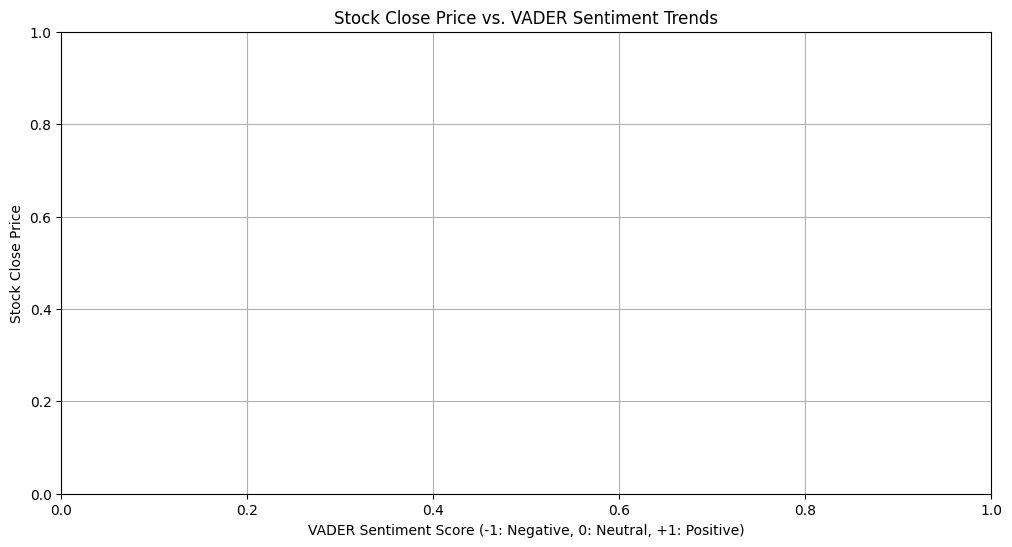


⚠️ Not enough data points to compute Pearson Correlation.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 🔹 Load the ordered financial dataset and VADER sentiment analysis results
df_ordered = pd.read_csv("ordered_financial_data.csv")
df_vader = pd.read_csv("vader_sentiment_analysis_results.csv")

# 🔹 Convert Date column to datetime format
df_ordered["Date"] = pd.to_datetime(df_ordered["Date"])
df_vader["Date"] = pd.to_datetime(df_vader["Date"])

# 🔹 Manually align sentiment scores by iterating through the datasets
sentiment_scores = []
close_prices = []

for index, row in df_ordered.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]

    # Find matching sentiment score in df_vader
    sentiment_row = df_vader[(df_vader["Ticker"] == ticker) & (df_vader["Date"] == date)]

    if not sentiment_row.empty:
        sentiment_scores.append(sentiment_row["Sentiment Score"].values[0])
        close_prices.append(row["Close"])

# 🔹 Ensure lists have values before computing correlation
if len(sentiment_scores) > 1 and len(close_prices) > 1:
    pearson_corr, _ = pearsonr(sentiment_scores, close_prices)
else:
    pearson_corr = None

# 📊 Plot Stock Performance vs. Sentiment Trends
plt.figure(figsize=(12, 6))
sns.scatterplot(x=sentiment_scores, y=close_prices, alpha=0.6)
plt.title(f"Stock Close Price vs. VADER Sentiment Trends (Correlation: {pearson_corr:.2f})" if pearson_corr else "Stock Close Price vs. VADER Sentiment Trends")
plt.xlabel("VADER Sentiment Score (-1: Negative, 0: Neutral, +1: Positive)")
plt.ylabel("Stock Close Price")
plt.grid(True)
plt.show()

# ✅ Display correlation result
if pearson_corr:
    print(f"\n✅ Pearson Correlation between VADER Sentiment & Stock Close Price: {pearson_corr:.2f}")
else:
    print("\n⚠️ Not enough data points to compute Pearson Correlation.")

In [ ]:

# Define the date range from January to June 2022 (trialed on small dataset) - changed to Jan 2022 to Dec 2024 for evaluation
date_range = pd.date_range(start="2022-01-01", end="2024-12-31", freq='D')

# Create a DataFrame
df_dates = pd.DataFrame(date_range, columns=["Date"])

# Save to CSV
df_dates.to_csv("dates_jan_jun_2022.csv", index=False)

print("\n✅ CSV file 'dates_jan_jun_2022.csv' created successfully!")


✅ CSV file 'dates_jan_jun_2022.csv' created successfully!


In [ ]:

# Load the financial data (Ensure the correct file path)
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")

# Extract unique tickers
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]
tickers_new = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]

# Create a DataFrame
df_tickers = pd.DataFrame(tickers_new, columns=["Ticker"])

# Save to CSV
df_tickers.to_csv("ticker_list.csv", index=False)

print("\n✅ CSV file 'ticker_list.csv' created successfully!")


✅ CSV file 'ticker_list.csv' created successfully!


In [ ]:
#Training of Anthropic Claude using Chain-of-Thought prompting and Reinforcement Learning

# 🔹 Load the sorted financial news and numerical stock data
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_financials2 = pd.read_csv("sorted_financial_numerical_data_two.csv")
# 🔹 Convert Date column to datetime format
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_financials2["Date"] = pd.to_datetime(df_financials2["Date"])
# 🔹 Initialize Anthropic Claude API
CLAUDE_API_KEY = ""  # Replace with your actual API key
client = anthropic.Anthropic(api_key=CLAUDE_API_KEY)

# ✅ Step 1: Sentiment Prediction (Save to CSV)
sentiment_results = []
begin = time.time()
sentiment_prompt_template = """
You are an AI trained for financial sentiment analysis.
You will, in the future, be prompted to perform predictions on financial information.
Analyze the financial news article below and assign a sentiment score between -1 (Negative), 0 (Neutral), and +1 (Positive).
Use the sentiment of these articles, and their dates, to assist you in your predictions further down the line.

Article: "{article}"
---
Final Answer: [Numeric Sentiment Score]
"""

for index, row in df_news.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]
    article_text = row["Cleaned Title"]

    # Format sentiment prompt
    formatted_prompt = sentiment_prompt_template.format(article=article_text)

    # Query Claude for sentiment analysis
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=50,
        temperature=0.5,
        messages=[{"role": "user", "content": formatted_prompt}]
    )

    # Extract sentiment prediction
    response_text = response.content[0].text
    try:
        predicted_sentiment = float(response_text.split("Final Answer: ")[-1].strip())
    except ValueError:
        predicted_sentiment = None

    # Store result
    sentiment_results.append({"Ticker": ticker, "Date": date, "Sentiment Score": predicted_sentiment})

# Save sentiment predictions to CSV
df_sentiment = pd.DataFrame(sentiment_results)
df_sentiment.to_csv("claude_sentiment_predictions.csv", index=False)
print("\n✅ Sentiment analysis results saved to 'claude_sentiment_predictions.csv'")

# ✅ Step 2: Stock Price Prediction with Reinforcement Learning
reward_score = 0  # Start with neutral reward

stock_prediction_prompt_template = """
You are an AI trained for financial market forecasting.
Analyze the given financial data and predict the next day's closing stock price step by step. Limit your answer to 500 characters.
You have already been fed financial news articles pertinent to the time period of the given financial data.
If possible, use that information as well

1. **Identify Historical Market Trends**: Examine the last few days' price trends.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Identify macro trends affecting the asset.
4. **Compute Expected Price Movement**: Use past patterns to estimate the next day's close price.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Additionally, if the date is the last date of the month, provide the predicted next-day closing stock price.
Only provide a numerical value for the predicted next-day closing stock price.
If you are providing a predicted next-day closing stock price, please do so in the format -> Predicted Next-Day Close Price: NUM.
---
Ticker: {ticker}
Date: {date}
Previous Close: {prev_close}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Next-Day Close Price** → [Numeric value]
"""

for index in range(len(df_financials) - 1):  # Iterate through financial data
    row_financials = df_financials.iloc[index]
    print(row_financials)
    ticker = row_financials["Ticker"]
    date = row_financials["Date"]
    prev_close = row_financials["Adj Close"]

    # Format the stock prediction prompt
    formatted_prompt = stock_prediction_prompt_template.format(
        ticker=ticker, date=date, prev_close=prev_close
    )

    # Send the prompt to Claude AI
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=500,
        temperature=0.5,
        messages=[{"role": "user", "content": formatted_prompt}]
    )
    print("Response: " + str(response))
    # Extract Claude's predicted next-day close price
    response_text = response.content[0].text
    try:
        predicted_close = float(response_text.split("Predicted Next-Day Close Price: ")[-1].strip())
    except ValueError:
        predicted_close = None

    # Get the actual next-day stock close price
    next_day_financials = df_financials[
        (df_financials["Ticker"] == ticker) & (df_financials["Date"] == date + pd.Timedelta(days=1))
    ]

    if next_day_financials.empty or predicted_close is None:
        continue  # Skip if no next-day data or prediction failed

    actual_close = next_day_financials["Adj Close"].values[0]

    # 🔹 Compute reward/penalty based on prediction accuracy (Mean Squared Error approach)
    error = abs(predicted_close - actual_close)
    reward_score -= error  # Penalize large errors, reward small errors

    # 🔹 Update Prompt for Next Iteration Based on Reinforcement Learning
    if reward_score < -1:
        formatted_prompt += "\n\n⚠️ Previous predictions had large errors. Pay closer attention to price trends."
    elif reward_score > 1:
        formatted_prompt += "\n\n✅ Previous predictions have been accurate. Continue applying the same logic."

    # 🔹 Print results
    print(f"✅ {ticker} - {date}")
    print(f"🔹 Predicted Close: {predicted_close}")
    print(f"🔹 Actual Close: {actual_close}")
    print(f"🔹 Prediction Error: {error:.2f}")
    print(f"🔹 Reward Score: {reward_score}")
    print("-" * 50)

print("\n✅ Training complete! Claude AI has processed financial news for sentiment and adapted stock price forecasting using reinforcement learning.")

predictions = []
explanations = []

stock_prediction_two_prompt_template = """
You are an AI trained for financial market forecasting.
You have already been fed with financial news articles and numerical data for the year 2021, and were trained to make accurate predictions.
Now, you will be fed with dates from 2022 and be asked to use your prior knowledge and training to make predictions.
Using the knowledge gained from previous financial data, predict the closing stock price for the given dates.

1. **Identify Historical Market Trends**: Examine previous trends based on past learned patterns.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Consider economic trends that could affect stock price movement.
4. **Compute Expected Price Movement**: Estimate the likely close price for the given date.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Only provide the predicted closing stock price in the format -> Predicted Close Price: NUM.
---
Ticker: {ticker}
Date: {date}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Close Price** → [Numeric value]
"""


# ✅ Step 3: Predict Closing Prices for January - June 2022
print("\n🚀 Now predicting closing prices for January - June 2022...")
# Iterate through all tickers and all dates between Jan and June 2022

df_dates = pd.read_csv("dates_jan_jun_2022.csv", dtype={"Date": str})

tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]
numofClaudeValues = 0
numofactualCValues = 0
for ticker in tickers:

    for date in df_dates["Date"]:
        numofClaudeValues = numofClaudeValues + 1
        # Format the stock prediction prompt
        formatted_prompt = stock_prediction_two_prompt_template.format(
            ticker=ticker, date=date
        )

        # Send the prompt to Claude AI
        response = client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=500,
            temperature=0.5,
            messages=[{"role": "user", "content": formatted_prompt}]
        )

        # Extract Claude's predicted closing price
        response_text = response.content[0].text
        try:
            predicted_close = float(response_text.split("Predicted Close Price: ")[-1].strip())
            numofactualCValues = numofactualCValues + 1
        except ValueError:
            predicted_close = None

        explanation = response_text.split("Final Prediction:\n- **Explanation** → ")[-1].split("\n- **Predicted Close Price**")[0].strip()

        # Store results
        predictions.append({
            "Ticker": ticker,
            "Date": date,
            "Predicted Close Price": predicted_close
        })

        explanations.append({
            "Ticker": ticker,
            "Date": date,
            "Explanation": explanation
        })

        # Print progress
        print(f"✅ Predicted for {ticker} on {date}: {predicted_close}")

time.sleep(1)
end = time.time()
totalClaudetime = (end-begin)
# 🔹 Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv("claude_predictions_jan_jun_2022.csv", index=False)
df_explanations = pd.DataFrame(explanations)
df_explanations.to_csv("claude_explanations_jan_jun_2022.csv", index=False)

print("\n✅ Predictions saved to 'claude_predictions_jan_jun_2022.csv'")
print("\n✅ Explanations saved to 'claude_explanations_jan_jun_2022.csv'")


✅ Sentiment analysis results saved to 'claude_sentiment_predictions.csv'
Date         2021-12-21 00:00:00-05:00
Ticker                            AAPL
Open                          0.379677
High                          0.379862
Low                           0.365417
Close                         0.388835
Volume                        0.989322
Adj Close                     0.388835
Name: 0, dtype: object
Response: Message(id='msg_01Dh2Q57zmfm6FoNnfZZuP6Y', content=[TextBlock(citations=None, text="Based on the limited data provided, I can see AAPL closed at $0.3888 on Dec 21, 2021. This appears to be split-adjusted data.\n\nLooking at historical trends, December 2021 was positive for tech stocks after November volatility. AAPL was approaching its $3T market cap milestone with strong holiday sales momentum and investor optimism about its product pipeline.\n\nWithout complete volume data, I'd predict slight upward movement based on seasonal strength and positive market sentiment.\n\nPred

In [ ]:
#Training of ChatGPT using Chain-of-Thought Prompting and Reinforcement Learning


# 🔹 Load the sorted financial news and numerical stock data
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_financials2 = pd.read_csv("sorted_financial_numerical_data_two.csv")
# 🔹 Convert Date column to datetime format
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_financials2["Date"] = pd.to_datetime(df_financials2["Date"])

OPENAI_API_KEY = ''
openai.api_key = OPENAI_API_KEY


sentiment_results = []
begin = time.time()
sentiment_prompt_template = """
You are an AI trained for financial sentiment analysis.
You will, in the future, be prompted to perform predictions on financial information.
Analyze the financial news article below and assign a sentiment score between -1 (Negative), 0 (Neutral), and +1 (Positive).
Use the sentiment of these articles, and their dates, to assist you in your predictions further down the line.
Article: "{article}"
---
Final Answer: [Numeric Sentiment Score]
"""

for index, row in df_news.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]
    article_text = row["Cleaned Title"]

    # Format sentiment prompt
    formatted_prompt = sentiment_prompt_template.format(article=article_text)

    # Query GPT-4 for sentiment analysis
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": formatted_prompt}],
        max_tokens=50,
        temperature=0.5
    )

    # Extract sentiment prediction
    response_text = response["choices"][0]["message"]["content"]
    try:
        predicted_sentiment = float(response_text.split("Final Answer: ")[-1].strip())
    except ValueError:
        predicted_sentiment = None

    # Store result
    sentiment_results.append({"Ticker": ticker, "Date": date, "Sentiment Score": predicted_sentiment})

# Save sentiment predictions to CSV
df_sentiment = pd.DataFrame(sentiment_results)
df_sentiment.to_csv("gpt_sentiment_predictions.csv", index=False)
print("\n✅ Sentiment analysis results saved to 'gpt_sentiment_predictions.csv'")

# ✅ Step 2: Stock Price Prediction with Reinforcement Learning
reward_score = 0

stock_prediction_prompt_template = """
You are an AI trained for financial market forecasting.
Analyze the given financial data and predict the next day's closing stock price step by step. Limit your answer to 500 characters.
You have already been fed financial news articles pertinent to the time period of the given financial data.
If possible, use that information as well.

1. **Identify Historical Market Trends**: Examine the last few days' price trends.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Identify macro trends affecting the asset.
4. **Compute Expected Price Movement**: Use past patterns to estimate the next day's close price.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Additionally, if the date is the last date of the month, provide the predicted next-day closing stock price.
Only provide a numerical value for the predicted next-day closing stock price.
If you are providing a predicted next-day closing stock price, please do so in the format -> Predicted Next-Day Close Price: NUM.
---
Ticker: {ticker}
Date: {date}
Previous Close: {prev_close}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Next-Day Close Price** → [Numeric value]
"""

for index in range(len(df_financials) - 1):  # Iterate through financial data
    row_financials = df_financials.iloc[index]

    ticker = row_financials["Ticker"]
    date = row_financials["Date"]
    prev_close = row_financials["Adj Close"]

    # Format the stock prediction prompt
    formatted_prompt = stock_prediction_prompt_template.format(
        ticker=ticker, date=date, prev_close=prev_close
    )

    # Send the prompt to GPT-4
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": formatted_prompt}],
        max_tokens=500,
        temperature=0.5
    )

    # Extract GPT-4's predicted next-day close price
    response_text = response["choices"][0]["message"]["content"]
    try:
        predicted_close = float(response_text.split("Predicted Next-Day Close Price: ")[-1].strip())
    except ValueError:
        predicted_close = None

    # Get the actual next-day stock close price
    next_day_financials = df_financials[
        (df_financials["Ticker"] == ticker) & (df_financials["Date"] == date + pd.Timedelta(days=1))
    ]

    if next_day_financials.empty or predicted_close is None:
        continue  # Skip if no next-day data or prediction failed

    actual_close = next_day_financials["Adj Close"].values[0]

    # 🔹 Compute reward/penalty based on prediction accuracy (Mean Squared Error approach)
    error = abs(predicted_close - actual_close)
    reward_score -= error  # Penalize large errors, reward small errors

    # 🔹 Update Prompt for Next Iteration Based on Reinforcement Learning
    if reward_score < -1:
        formatted_prompt += "\n\n⚠️ Previous predictions had large errors. Pay closer attention to price trends."
    elif reward_score > 1:
        formatted_prompt += "\n\n✅ Previous predictions have been accurate. Continue applying the same logic."

    # 🔹 Print results
    print(f"✅ {ticker} - {date}")
    print(f"🔹 Predicted Close: {predicted_close}")
    print(f"🔹 Actual Close: {actual_close}")
    print(f"🔹 Prediction Error: {error:.2f}")
    print(f"🔹 Reward Score: {reward_score}")
    print("-" * 50)

print("\n✅ Training complete! GPT-4 has processed financial news for sentiment and adapted stock price forecasting using reinforcement learning.")



predictions = []
explanations = []

stock_prediction_two_prompt_template = """
You are an AI trained for financial market forecasting.
You have already been fed with financial news articles and numerical data for the year 2021, and were trained to make accurate predictions.
Now, you will be fed with dates from 2022 and be asked to use your prior knowledge and training to make predictions.
Using the knowledge gained from previous financial data, predict the closing stock price for the given dates.

1. **Identify Historical Market Trends**: Examine previous trends based on past learned patterns.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Consider economic trends that could affect stock price movement.
4. **Compute Expected Price Movement**: Estimate the likely close price for the given date.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Only provide the predicted closing stock price in the format -> Predicted Close Price: NUM.
---
Ticker: {ticker}
Date: {date}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Close Price** → [Numeric value]
"""
#tickers = [
#    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
#]


print("\n🚀 Now predicting closing prices for January - June 2022...")
numofGPTvalues = 0
numofactualvalues = 0
for ticker in tickers:
    for date in df_dates["Date"]:
        numofGPTvalues = numofGPTvalues + 1
        # Format the stock prediction prompt
        formatted_prompt = stock_prediction_two_prompt_template.format(
            ticker=ticker, date=date
        )

        # Send the prompt to OpenAI GPT-4
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": formatted_prompt}],
            max_tokens=500,
            temperature=0.5
        )


        # Extract GPT-4's predicted closing price
        response_text = response["choices"][0]["message"]["content"]

        try:
            predicted_close = float(response_text.split("**Predicted Close Price** → ")[-1].strip())
            numofactualvalues = numofactualvalues + 1
        except ValueError:
            predicted_close = None

        explanation = response_text.split("Final Prediction:\n- **Explanation** → ")[-1].split("\n- **Predicted Close Price**")[0].strip()

        # Store results
        predictions.append({
            "Ticker": ticker,
            "Date": date,
            "Predicted Close Price": predicted_close
        })

        explanations.append({
            "Ticker": ticker,
            "Date": date,
            "Explanation": explanation
        })


        # Print progress
        print(f"✅ Predicted for {ticker} on {date}: {predicted_close}")
time.sleep(1)
end = time.time()
totalGPTtime = (end-begin)
# 🔹 Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv("gpt4_predictions_jan_jun_2022.csv", index=False)

df_explanations = pd.DataFrame(explanations)
df_explanations.to_csv("gpt4_explanations_jan_jun_2022.csv", index=False)

print("\n✅ Predictions saved to 'gpt4_predictions_jan_jun_2022.csv'")
print("\n✅ Explanations saved to 'gpt4_explanations_jan_jun_2022.csv'")



✅ Sentiment analysis results saved to 'gpt_sentiment_predictions.csv'
✅ AAPL - 2021-12-28 00:00:00-05:00
🔹 Predicted Close: 0.485
🔹 Actual Close: 0.4784635375891523
🔹 Prediction Error: 0.01
🔹 Reward Score: -0.00653646241084771
--------------------------------------------------
✅ AAPL - 2021-12-29 00:00:00-05:00
🔹 Predicted Close: 0.48
🔹 Actual Close: 0.4619123724440075
🔹 Prediction Error: 0.02
🔹 Reward Score: -0.02462408996684018
--------------------------------------------------
✅ AMZN - 2021-12-29 00:00:00-05:00
🔹 Predicted Close: 0.38
🔹 Actual Close: 0.3692752378428324
🔹 Prediction Error: 0.01
🔹 Reward Score: -0.03534885212400779
--------------------------------------------------
✅ DIS - 2021-12-21 00:00:00-05:00
🔹 Predicted Close: 0.092
🔹 Actual Close: 0.1035652633502199
🔹 Prediction Error: 0.01
🔹 Reward Score: -0.04691411547422769
--------------------------------------------------
✅ DIS - 2021-12-27 00:00:00-05:00
🔹 Predicted Close: 0.118
🔹 Actual Close: 0.1503694575112429
🔹 Pred

In [ ]:
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN=userdata.get('test_token')

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please save the token first.")

Successfully logged in to Hugging Face!


In [ ]:
#Training of Meta LLaMa : Use a GPU to run this - Did not use this, but could do future work involving it

'''!pip install torch transformers accelerate sentencepiece

import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# 🔹 Load the sorted financial news and numerical stock data
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")

# 🔹 Convert Date column to datetime format
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])

# 🔹 Load Meta LLaMA 3.2 3B Instruct Model & Tokenizer
model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# ✅ Step 1: Sentiment Prediction (Save to CSV)
sentiment_results = []
begin = time.time()
sentiment_prompt_template = """
You are an AI trained for financial sentiment analysis.
You will, in the future, be prompted to perform predictions on financial information.
Analyze the financial news article below and assign a sentiment score between -1 (Negative), 0 (Neutral), and +1 (Positive).
Use the sentiment of these articles, and their dates, to assist you in your predictions further down the line.

Article: "{article}"
---
Final Answer: [Numeric Sentiment Score]
"""

for index, row in df_news.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]
    article_text = row["Cleaned Title"]

    # Format sentiment prompt
    formatted_prompt = sentiment_prompt_template.format(article=article_text)

    # Tokenize and generate output from LLaMA
    response = pipe(formatted_prompt, max_new_tokens=200)
    response_text = response[0]["generated_text"]

    # Extract sentiment prediction
    try:
        predicted_sentiment = float(response_text.split("Final Answer: ")[-1].strip())
    except ValueError:
        predicted_sentiment = None

    # Store result
    sentiment_results.append({"Ticker": ticker, "Date": date, "Sentiment Score": predicted_sentiment})

# Save sentiment predictions to CSV
df_sentiment = pd.DataFrame(sentiment_results)
df_sentiment.to_csv("llama_sentiment_predictions.csv", index=False)
print("\n✅ Sentiment analysis results saved to 'llama_sentiment_predictions.csv'")

# ✅ Step 2: Stock Price Prediction with Reinforcement Learning
reward_score = 0  # Start with neutral reward

stock_prediction_prompt_template = """
You are an AI trained for financial market forecasting.
Analyze the given financial data and predict the next day's closing stock price step by step. Limit your answer to 500 characters.
You have already been fed financial news articles pertinent to the time period of the given financial data.
If possible, use that information as well.

1. **Identify Historical Market Trends**: Examine the last few days' price trends.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Identify macro trends affecting the asset.
4. **Compute Expected Price Movement**: Use past patterns to estimate the next day's close price.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Additionally, if the date is the last date of the month, provide the predicted next-day closing stock price.
Only provide a numerical value for the predicted next-day closing stock price.
If you are providing a predicted next-day closing stock price, please do so in the format -> Predicted Next-Day Close Price: NUM.
---
Ticker: {ticker}
Date: {date}
Previous Close: {prev_close}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Next-Day Close Price** → [Numeric value]
"""

for index in range(len(df_financials) - 1):  # Iterate through financial data
    row_financials = df_financials.iloc[index]

    ticker = row_financials["Ticker"]
    date = row_financials["Date"]
    prev_close = row_financials["Close"]

    # Format the stock prediction prompt
    formatted_prompt = stock_prediction_prompt_template.format(
        ticker=ticker, date=date, prev_close=prev_close
    )

    # Tokenize and generate output from LLaMA
    response = pipe(formatted_prompt, max_new_tokens=200)
    response_text = response[0]["generated_text"]

    # Extract LLaMA's predicted next-day close price
    try:
        predicted_close = float(response_text.split("Predicted Next-Day Close Price: ")[-1].strip())
    except ValueError:
        predicted_close = None

    # Get the actual next-day stock close price
    next_day_financials = df_financials[
        (df_financials["Ticker"] == ticker) & (df_financials["Date"] == date + pd.Timedelta(days=1))
    ]

    if next_day_financials.empty or predicted_close is None:
        continue  # Skip if no next-day data or prediction failed

    actual_close = next_day_financials["Close"].values[0]

    # 🔹 Compute reward/penalty based on prediction accuracy (Mean Squared Error approach)
    error = abs(predicted_close - actual_close)
    reward_score -= error  # Penalize large errors, reward small errors

    # 🔹 Update Prompt for Next Iteration Based on Reinforcement Learning
    if reward_score < -1:
        formatted_prompt += "\n\n⚠️ Previous predictions had large errors. Pay closer attention to price trends."
    elif reward_score > 1:
        formatted_prompt += "\n\n✅ Previous predictions have been accurate. Continue applying the same logic."

    # 🔹 Print results
    print(f"✅ {ticker} - {date}")
    print(f"🔹 Predicted Close: {predicted_close}")
    print(f"🔹 Actual Close: {actual_close}")
    print(f"🔹 Prediction Error: {error:.2f}")
    print(f"🔹 Reward Score: {reward_score}")
    print("-" * 50)

print("\n✅ Training complete! LLaMA 3.2 has processed financial news for sentiment and adapted stock price forecasting using reinforcement learning.")

predictions = []
explanations = []

stock_prediction_two_prompt_template = """
You are an AI trained for financial market forecasting.
You have already been fed with financial news articles and numerical data for the year 2021, and were trained to make accurate predictions.
Now, you will be fed with dates from 2022 and be asked to use your prior knowledge and training to make predictions.
Using the knowledge gained from previous financial data, predict the closing stock price for the given dates.

1. **Identify Historical Market Trends**: Examine previous trends based on past learned patterns.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Consider economic trends that could affect stock price movement.
4. **Compute Expected Price Movement**: Estimate the likely close price for the given date.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Only provide the predicted closing stock price in the format -> Predicted Close Price: NUM.
---
Ticker: {ticker}
Date: {date}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Close Price** → [Numeric value]
"""
numofLlamaValues = 0
numofactualLvalues = 0
for ticker in tickers:
    for date in df_dates["Date"]:
      numofLlamaValues = numofLlamaValues + 1
        # Format the stock prediction prompt
        formatted_prompt = stock_prediction_prompt_template.format(
            ticker=ticker, date=date
        )

        response = pipe(formatted_prompt, max_new_tokens=200)
        response_text = response[0]["generated_text"]

        # Extract LLaMA’s predicted closing price
        try:
            predicted_close = float(response_text.split("Predicted Close Price: ")[-1].strip())
            numofactualLvalues=numofactualLvalues+1
        except ValueError:
            predicted_close = None

       explanation = response_text.split("Final Prediction:\n- **Explanation** → ")[-1].split("\n- **Predicted Close Price**")[0].strip()

        # Store results
        predictions.append({
            "Ticker": ticker,
            "Date": date,
            "Predicted Close Price": predicted_close
        })

        explanations.append({
            "Ticker": ticker,
            "Date": date,
            "Explanation": explanation
        })

        # Print progress
        print(f"✅ Predicted for {ticker} on {date}: {predicted_close}")
#time.sleep(1)
#end = time.time()
#totalLlamatime = (end-begin)
# 🔹 Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv("llama_predictions_jan_jun_2022.csv", index=False)

# 🔹 Save explanations to CSV
df_explanations = pd.DataFrame(explanations)
df_explanations.to_csv("llama_explanations_jan_jun_2022.csv", index=False)

print("\n✅ Predictions saved to 'llama_predictions_jan_jun_2022.csv'")
print("\n✅ Explanations saved to 'llama_explanations_jan_jun_2022.csv'")
'''

'!pip install torch transformers accelerate sentencepiece\n\nimport pandas as pd\nimport torch\nfrom transformers import AutoModelForCausalLM, AutoTokenizer\n\n# 🔹 Load the sorted financial news and numerical stock data\ndf_news = pd.read_csv("sorted_financial_news.csv")\ndf_financials = pd.read_csv("sorted_financial_numerical_data.csv")\n\n# 🔹 Convert Date column to datetime format\ndf_news["Date"] = pd.to_datetime(df_news["Date"])\ndf_financials["Date"] = pd.to_datetime(df_financials["Date"])\n\n# 🔹 Load Meta LLaMA 3.2 3B Instruct Model & Tokenizer\nmodel_id = "meta-llama/Llama-3.2-3B-Instruct"\npipe = pipeline(\n    "text-generation",\n    model=model_id,\n    torch_dtype=torch.bfloat16,\n    device_map="auto",\n)\n\n# ✅ Step 1: Sentiment Prediction (Save to CSV)\nsentiment_results = []\nbegin = time.time()\nsentiment_prompt_template = """\nYou are an AI trained for financial sentiment analysis.\nYou will, in the future, be prompted to perform predictions on financial information.\n

In [ ]:
#Training of Google Gemini using Chain-of-Thought Prompting and Reinforcement Learning


df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_financials_new = pd.read_csv("financial_forecasting_cleaned.csv")
df_financials_new["Date"] = pd.to_datetime(df_news["Date"])
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_financials2 = pd.read_csv("sorted_financial_numerical_data_two.csv")
df_financials2["Date"] = pd.to_datetime(df_financials2["Date"])
reward_scores_list = []
GEMINI_API_KEY = ""  # Replace with actual API key
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

sentiment_results = []
begin = time.time()
sentiment_prompt_template = """
You are an AI trained for financial sentiment analysis.
You will, in the future, be prompted to perform predictions on financial information.
Analyze the financial news article below and assign a sentiment score between -1 (Negative), 0 (Neutral), and +1 (Positive).
Use the sentiment of these articles, and their dates, to assist you in your predictions further down the line.
Article: "{article}"
---
Final Answer: [Numeric Sentiment Score]
"""

for index, row in df_news.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]
    article_text = row["Cleaned Title"]

    # Format sentiment prompt
    formatted_prompt = sentiment_prompt_template.format(article=article_text)

    response = model.generate_content(formatted_prompt)

    try:
        predicted_sentiment = float(response.text.split("Final Answer: ")[-1].strip())
    except ValueError:
        predicted_sentiment = None

    # Store result
    sentiment_results.append({"Ticker": ticker, "Date": date, "Sentiment Score": predicted_sentiment})

# Save sentiment predictions to CSV
df_sentiment = pd.DataFrame(sentiment_results)
df_sentiment.to_csv("gemini_sentiment_predictions.csv", index=False)
print("\n✅ Sentiment analysis results saved to 'gemini_sentiment_predictions.csv'")

# ✅ Step 2: Stock Price Prediction with Reinforcement Learning
reward_score = 0

stock_prediction_prompt_template = """
You are an AI trained for financial market forecasting.
Analyze the given financial data and predict the next day's closing stock price step by step. Limit your answer to 500 characters.
You have already been fed financial news articles pertinent to the time period of the given financial data.
If possible, use that information as well.

1. **Identify Historical Market Trends**: Examine the last few days' price trends.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Identify macro trends affecting the asset.
4. **Compute Expected Price Movement**: Use past patterns to estimate the next day's close price.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Additionally, if the date is the last date of the month, provide the predicted next-day closing stock price.
Only provide a numerical value for the predicted next-day closing stock price.
If you are providing a predicted next-day closing stock price, please do so in the format -> Predicted Next-Day Close Price: NUM.
---
Ticker: {ticker}
Date: {date}
Previous Close: {prev_close}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Next-Day Close Price** → [Numeric value]
"""

for index in range(len(df_financials) - 1):  # Iterate through financial data
    row_financials = df_financials.iloc[index]

    ticker = row_financials["Ticker"]
    date = row_financials["Date"]
    prev_close = row_financials["Adj Close"]

    # Format the stock prediction prompt
    formatted_prompt = stock_prediction_prompt_template.format(
        ticker=ticker, date=date, prev_close=prev_close
    )


    response = model.generate_content(formatted_prompt)
    try:
        predicted_close = float(response.text.split("**Predicted Next-Day Close Price** → ")[-1].strip())
    except ValueError:
        predicted_close = None

    # Get the actual next-day stock close price
    next_day_financials = df_financials[
        (df_financials["Ticker"] == ticker) & (df_financials["Date"] == date + pd.Timedelta(days=1))
    ]

    if next_day_financials.empty or predicted_close is None:
        continue  # Skip if no next-day data or prediction failed

    actual_close = next_day_financials["Adj Close"].values[0]

    # 🔹 Compute reward/penalty based on prediction accuracy (Mean Squared Error approach)
    error = abs(predicted_close - actual_close)
    reward_score -= error  # Penalize large errors, reward small errors

    reward_scores_list.append({
        "Ticker": ticker,
        "Date": date,
        "Reward Score": reward_score
    })

    # 🔹 Update Prompt for Next Iteration Based on Reinforcement Learning
    if reward_score < -1:
        formatted_prompt += "\n\n⚠️ Previous predictions had large errors. Pay closer attention to price trends."
    elif reward_score > 1:
        formatted_prompt += "\n\n✅ Previous predictions have been accurate. Continue applying the same logic."

    # 🔹 Print results
    print(f"✅ {ticker} - {date}")
    print(f"🔹 Predicted Close: {predicted_close}")
    print(f"🔹 Actual Close: {actual_close}")
    print(f"🔹 Prediction Error: {error:.2f}")
    print(f"🔹 Reward Score: {reward_score}")
    print("-" * 50)

print("\n✅ Training complete! Gemini has processed financial news for sentiment and adapted stock price forecasting using reinforcement learning.")



predictions = []
explanations = []

stock_prediction_two_prompt_template = """
You are an AI trained for financial market forecasting.
You have already been fed with financial news articles and numerical data for the year 2021, and were trained to make accurate predictions.
Now, you will be fed with dates from 2022 and be asked to use your prior knowledge and training to make predictions.
Using the knowledge gained from previous financial data, predict the closing stock price for the given dates.
Limit your answer to 500 characters.

1. **Identify Historical Market Trends**: Examine previous trends based on past learned patterns.
2. **Assess Trading Volume**: Identify how volume has impacted price changes.
3. **Compare Market Conditions**: Consider economic trends that could affect stock price movement.
4. **Compute Expected Price Movement**: Estimate the likely close price for the given date.
5. **Justify Your Prediction**: Explain why the predicted price movement is logical.

Based on your analysis, provide an explanation.
Only provide the predicted closing stock price in the format -> Predicted Close Price: NUM.
---
Ticker: {ticker}
Date: {date}

Final Prediction:
- **Explanation** → [Detailed reasoning]
- **Predicted Close Price** → [Numeric value]
"""
#tickers = [
#    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
#]


print("\n🚀 Now predicting closing prices for January - June 2022...")
numofGeminivalues = 0
numofactualGvalues = 0
for ticker in tickers:
    for date in df_dates["Date"]:
        numofGeminivalues = numofGeminivalues + 1
        # Format the stock prediction prompt
        formatted_prompt = stock_prediction_two_prompt_template.format(
            ticker=ticker, date=date
        )

        response = model.generate_content(formatted_prompt)
        try:
            predicted_close = float(response.text.split("**Predicted Close Price** → ")[-1].strip())
            numofactualGvalues = numofactualGvalues + 1
        except ValueError:
            predicted_close = None

        explanation = response.text.split("Final Prediction:\n- **Explanation** → ")[-1].split("\n- **Predicted Close Price**")[0].strip()

        # Store results
        predictions.append({
            "Ticker": ticker,
            "Date": date,
            "Predicted Close Price": predicted_close
        })

        explanations.append({
            "Ticker": ticker,
            "Date": date,
            "Explanation": explanation
        })


        # Print progress
        print(f"✅ Predicted for {ticker} on {date}: {predicted_close}")
time.sleep(1)
end = time.time()
totalGeminitime = (end-begin)
# 🔹 Save predictions to CSV
df_rewards = pd.DataFrame(reward_scores_list)
df_rewards.to_csv("gemini_reward_scores_training.csv", index=False)
print("\n✅ Reward scores saved to 'gemini_reward_scores_training.csv'")

df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv("gemini_predictions_jan_jun_2022.csv", index=False)

df_explanations = pd.DataFrame(explanations)
df_explanations.to_csv("gemini_explanations_jan_jun_2022.csv", index=False)

print("\n✅ Predictions saved to 'gemini_predictions_jan_jun_2022.csv'")
print("\n✅ Explanations saved to 'gemini_explanations_jan_jun_2022.csv'")



✅ Sentiment analysis results saved to 'gemini_sentiment_predictions.csv'
✅ AAPL - 2021-12-27 00:00:00-05:00
🔹 Predicted Close: 0.493
🔹 Actual Close: 0.4772009077520202
🔹 Prediction Error: 0.02
🔹 Reward Score: -0.015799092247979818
--------------------------------------------------
✅ AAPL - 2021-12-28 00:00:00-05:00
🔹 Predicted Close: 0.4772
🔹 Actual Close: 0.4784635375891523
🔹 Prediction Error: 0.00
🔹 Reward Score: -0.01706262983713208
--------------------------------------------------
✅ AMZN - 2021-12-21 00:00:00-05:00
🔹 Predicted Close: 0.4
🔹 Actual Close: 0.4034204681486488
🔹 Prediction Error: 0.00
🔹 Reward Score: -0.02048309798578085
--------------------------------------------------
✅ AMZN - 2021-12-29 00:00:00-05:00
🔹 Predicted Close: 0.379
🔹 Actual Close: 0.3692752378428324
🔹 Prediction Error: 0.01
🔹 Reward Score: -0.03020786014294846
--------------------------------------------------
✅ DIS - 2021-12-27 00:00:00-05:00
🔹 Predicted Close: 0.117
🔹 Actual Close: 0.1503694575112429


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

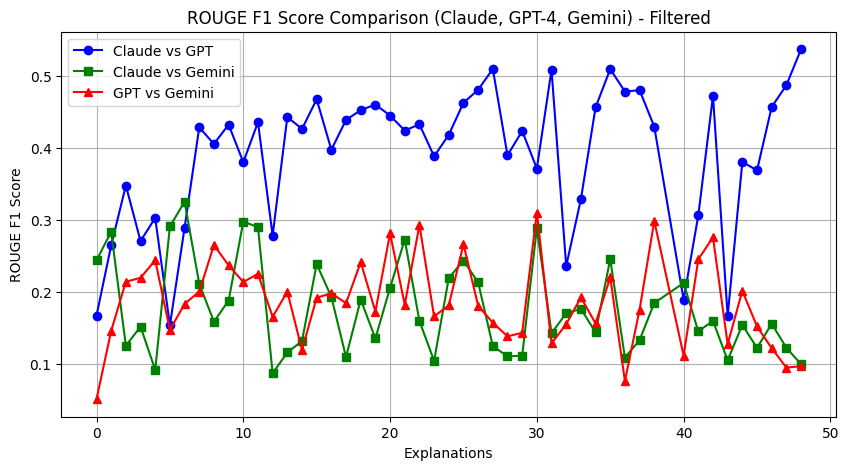

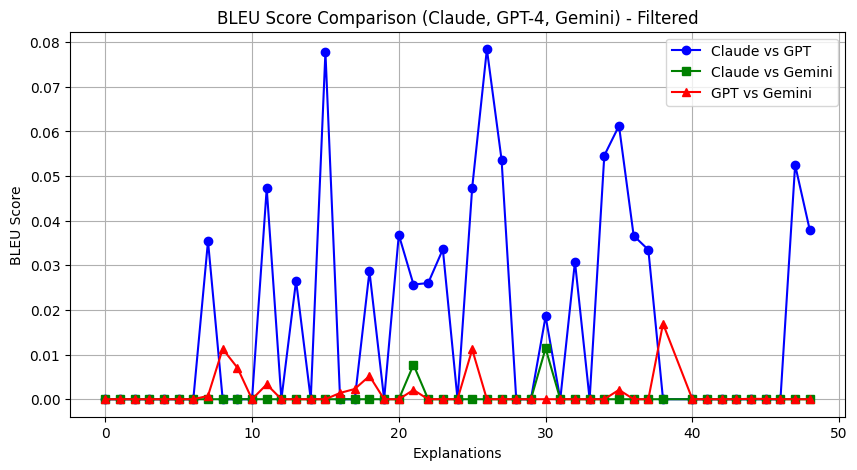


✅ Filtered ROUGE F1 and BLEU scores computed and saved to 'llm_explanation_comparison_filtered.csv'.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# 🔹 Load the explanation CSV files
df_claude = pd.read_csv("claude_explanations_jan_jun_2022.csv")
df_gpt = pd.read_csv("gpt4_explanations_jan_jun_2022.csv")
df_gemini = pd.read_csv("gemini_explanations_jan_jun_2022.csv")

# 🔹 Merge explanations based on Ticker and Date
df_merged = pd.merge(df_claude, df_gpt, on=["Ticker", "Date"], suffixes=("_claude", "_gpt"))
df_merged = pd.merge(df_merged, df_gemini, on=["Ticker", "Date"])
df_merged.rename(columns={"Explanation": "Explanation_gemini"}, inplace=True)

# 🔹 Initialize ROUGE scorer
rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# 🔹 Compute ROUGE-F1 and BLEU scores
rouge_f1_scores_claude_gpt = []
bleu_scores_claude_gpt = []

rouge_f1_scores_claude_gemini = []
bleu_scores_claude_gemini = []

rouge_f1_scores_gpt_gemini = []
bleu_scores_gpt_gemini = []

for _, row in df_merged.iterrows():
    explanation_claude = str(row["Explanation_claude"])
    explanation_gpt = str(row["Explanation_gpt"])
    explanation_gemini = str(row["Explanation_gemini"])

    # Compute ROUGE-F1 scores
    rouge_scores_claude_gpt = rouge_scorer_instance.score(explanation_claude, explanation_gpt)
    rouge_scores_claude_gemini = rouge_scorer_instance.score(explanation_claude, explanation_gemini)
    rouge_scores_gpt_gemini = rouge_scorer_instance.score(explanation_gpt, explanation_gemini)

    rouge_f1_scores_claude_gpt.append(rouge_scores_claude_gpt["rouge1"].fmeasure)
    rouge_f1_scores_claude_gemini.append(rouge_scores_claude_gemini["rouge1"].fmeasure)
    rouge_f1_scores_gpt_gemini.append(rouge_scores_gpt_gemini["rouge1"].fmeasure)

    # Compute BLEU scores
    reference_claude = explanation_claude.split()
    candidate_gpt = explanation_gpt.split()
    candidate_gemini = explanation_gemini.split()

    bleu_score_claude_gpt = sentence_bleu([reference_claude], candidate_gpt)
    bleu_score_claude_gemini = sentence_bleu([reference_claude], candidate_gemini)
    bleu_score_gpt_gemini = sentence_bleu([candidate_gpt], candidate_gemini)

    if bleu_score_claude_gpt != 0:
        bleu_scores_claude_gpt.append(bleu_score_claude_gpt)
    if bleu_score_claude_gemini != 0:
        bleu_scores_claude_gemini.append(bleu_score_claude_gemini)
    if bleu_score_gpt_gemini != 0:
        bleu_scores_gpt_gemini.append(bleu_score_gpt_gemini)

# 🔹 Add scores to dataframe
df_merged["ROUGE_F1_Claude_GPT"] = rouge_f1_scores_claude_gpt


df_merged["ROUGE_F1_Claude_Gemini"] = rouge_f1_scores_claude_gemini


df_merged["ROUGE_F1_GPT_Gemini"] = rouge_f1_scores_gpt_gemini


bleu_scores_claude_gpt = [score if score > 0 else 0 for score in bleu_scores_claude_gpt]
bleu_scores_claude_gemini = [score if score > 0 else 0 for score in bleu_scores_claude_gemini]
bleu_scores_gpt_gemini = [score if score > 0 else 0 for score in bleu_scores_gpt_gemini]

# Ensure lists have the same length as the DataFrame by filling missing values
while len(bleu_scores_claude_gpt) < len(df_merged):
    bleu_scores_claude_gpt.append(0)

while len(bleu_scores_claude_gemini) < len(df_merged):
    bleu_scores_claude_gemini.append(0)

while len(bleu_scores_gpt_gemini) < len(df_merged):
    bleu_scores_gpt_gemini.append(0)

# Now assign safely
df_merged["BLEU_Claude_GPT"] = bleu_scores_claude_gpt
df_merged["BLEU_Claude_Gemini"] = bleu_scores_claude_gemini
df_merged["BLEU_GPT_Gemini"] = bleu_scores_gpt_gemini

# 🔹 Remove entries where any of the similarity scores are 0
df_filtered = df_merged[
    (df_merged["ROUGE_F1_Claude_GPT"] > 0) & (df_merged["BLEU_Claude_GPT"] > 0) &
    (df_merged["ROUGE_F1_Claude_Gemini"] > 0) & (df_merged["BLEU_Claude_Gemini"] > 0) &
    (df_merged["ROUGE_F1_GPT_Gemini"] > 0) & (df_merged["BLEU_GPT_Gemini"] > 0)
]

# 🔹 Save the filtered results to CSV
df_filtered.to_csv("llm_explanation_comparison_filtered.csv", index=False)

# 🔹 Plot ROUGE-F1 scores
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_GPT"], label="Claude vs GPT", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_Gemini"], label="Claude vs Gemini", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_GPT_Gemini"], label="GPT vs Gemini", color="red", marker="^", linestyle="-")

plt.xlabel("Explanations")
plt.ylabel("ROUGE F1 Score")
plt.title("ROUGE F1 Score Comparison (Claude, GPT-4, Gemini) - Filtered")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_GPT"], label="Claude vs GPT", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_Gemini"], label="Claude vs Gemini", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, df_filtered["BLEU_GPT_Gemini"], label="GPT vs Gemini", color="red", marker="^", linestyle="-")

plt.xlabel("Explanations")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison (Claude, GPT-4, Gemini) - Filtered")
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Filtered ROUGE F1 and BLEU scores computed and saved to 'llm_explanation_comparison_filtered.csv'.")


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

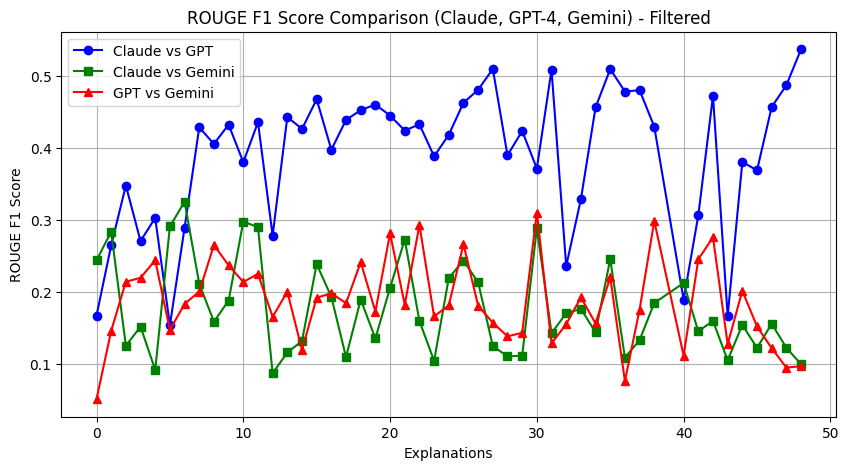

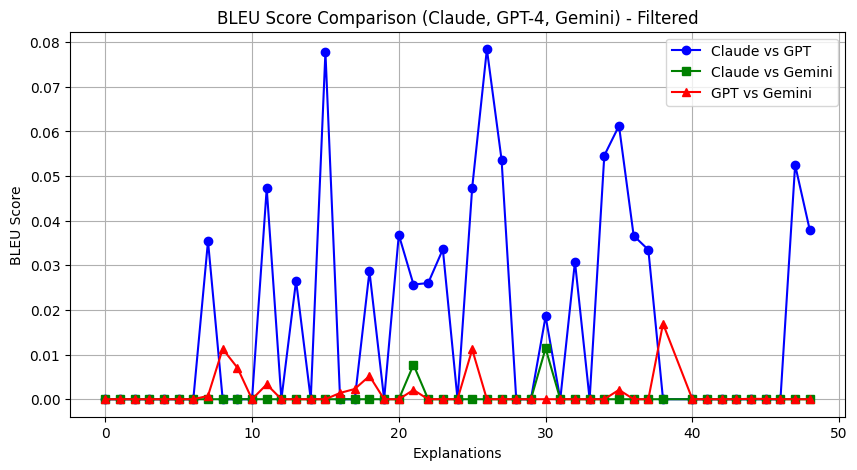

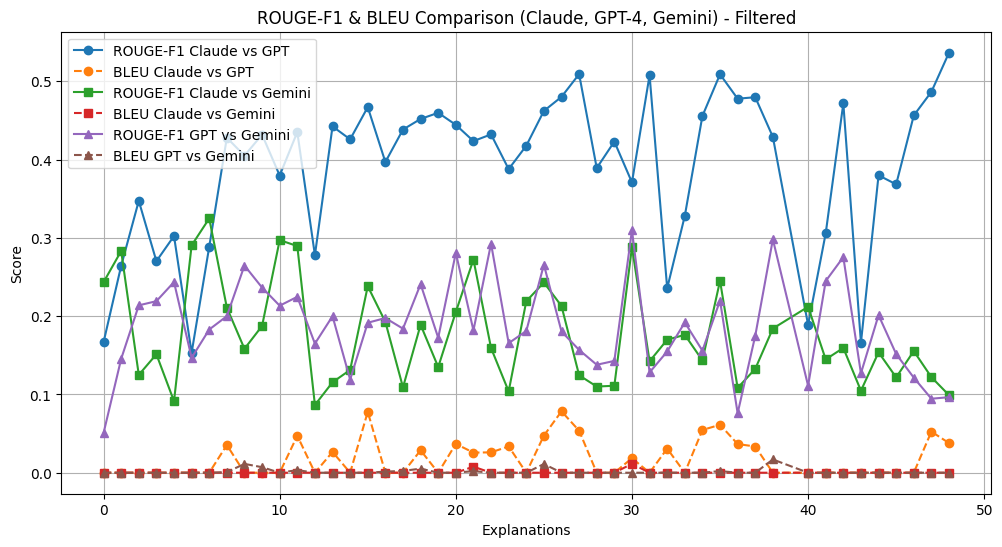

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# 🔹 Load explanation CSV files for Claude, GPT-4, and Gemini
df_claude = pd.read_csv("claude_explanations_jan_jun_2022.csv")
df_gpt = pd.read_csv("gpt4_explanations_jan_jun_2022.csv")
df_gemini = pd.read_csv("gemini_explanations_jan_jun_2022.csv")

# 🔹 Merge explanations based on Ticker and Date
df_merged = pd.merge(df_claude, df_gpt, on=["Ticker", "Date"], suffixes=("_claude", "_gpt"))
df_merged = pd.merge(df_merged, df_gemini, on=["Ticker", "Date"])
df_merged.rename(columns={"Explanation": "Explanation_gemini"}, inplace=True)

# 🔹 Initialize ROUGE scorer
rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# 🔹 Compute ROUGE-F1 and BLEU scores
rouge_f1_scores_claude_gpt = []
bleu_scores_claude_gpt = []

rouge_f1_scores_claude_gemini = []
bleu_scores_claude_gemini = []

rouge_f1_scores_gpt_gemini = []
bleu_scores_gpt_gemini = []

for _, row in df_merged.iterrows():
    explanation_claude = str(row["Explanation_claude"])
    explanation_gpt = str(row["Explanation_gpt"])
    explanation_gemini = str(row["Explanation_gemini"])

    # Compute ROUGE-F1 scores
    rouge_scores_claude_gpt = rouge_scorer_instance.score(explanation_claude, explanation_gpt)
    rouge_scores_claude_gemini = rouge_scorer_instance.score(explanation_claude, explanation_gemini)
    rouge_scores_gpt_gemini = rouge_scorer_instance.score(explanation_gpt, explanation_gemini)

    rouge_f1_scores_claude_gpt.append(rouge_scores_claude_gpt["rouge1"].fmeasure)
    rouge_f1_scores_claude_gemini.append(rouge_scores_claude_gemini["rouge1"].fmeasure)
    rouge_f1_scores_gpt_gemini.append(rouge_scores_gpt_gemini["rouge1"].fmeasure)

    # Compute BLEU scores
    reference_claude = explanation_claude.split()
    candidate_gpt = explanation_gpt.split()
    candidate_gemini = explanation_gemini.split()

    bleu_score_claude_gpt = sentence_bleu([reference_claude], candidate_gpt)
    bleu_score_claude_gemini = sentence_bleu([reference_claude], candidate_gemini)
    bleu_score_gpt_gemini = sentence_bleu([candidate_gpt], candidate_gemini)

    if bleu_score_claude_gpt != 0:
        bleu_scores_claude_gpt.append(bleu_score_claude_gpt)
    if bleu_score_claude_gemini != 0:
        bleu_scores_claude_gemini.append(bleu_score_claude_gemini)
    if bleu_score_gpt_gemini != 0:
        bleu_scores_gpt_gemini.append(bleu_score_gpt_gemini)

# 🔹 Add scores to dataframe
df_merged["ROUGE_F1_Claude_GPT"] = rouge_f1_scores_claude_gpt


df_merged["ROUGE_F1_Claude_Gemini"] = rouge_f1_scores_claude_gemini


df_merged["ROUGE_F1_GPT_Gemini"] = rouge_f1_scores_gpt_gemini


bleu_scores_claude_gpt = [score if score > 0 else 0 for score in bleu_scores_claude_gpt]
bleu_scores_claude_gemini = [score if score > 0 else 0 for score in bleu_scores_claude_gemini]
bleu_scores_gpt_gemini = [score if score > 0 else 0 for score in bleu_scores_gpt_gemini]

# Ensure lists have the same length as the DataFrame by filling missing values
while len(bleu_scores_claude_gpt) < len(df_merged):
    bleu_scores_claude_gpt.append(0)

while len(bleu_scores_claude_gemini) < len(df_merged):
    bleu_scores_claude_gemini.append(0)

while len(bleu_scores_gpt_gemini) < len(df_merged):
    bleu_scores_gpt_gemini.append(0)

# Now assign safely
df_merged["BLEU_Claude_GPT"] = bleu_scores_claude_gpt
df_merged["BLEU_Claude_Gemini"] = bleu_scores_claude_gemini
df_merged["BLEU_GPT_Gemini"] = bleu_scores_gpt_gemini

# 🔹 Remove entries where any of the similarity scores are 0
df_filtered = df_merged[
    (df_merged["ROUGE_F1_Claude_GPT"] > 0) & (df_merged["BLEU_Claude_GPT"] > 0) &
    (df_merged["ROUGE_F1_Claude_Gemini"] > 0) & (df_merged["BLEU_Claude_Gemini"] > 0) &
    (df_merged["ROUGE_F1_GPT_Gemini"] > 0) & (df_merged["BLEU_GPT_Gemini"] > 0)
]

# 🔹 Save the filtered results to CSV
df_filtered.to_csv("llm_explanation_comparison_filtered.csv", index=False)

# 🔹 Plot ROUGE-F1 scores
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_GPT"], label="Claude vs GPT", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_Gemini"], label="Claude vs Gemini", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_GPT_Gemini"], label="GPT vs Gemini", color="red", marker="^", linestyle="-")

plt.xlabel("Explanations")
plt.ylabel("ROUGE F1 Score")
plt.title("ROUGE F1 Score Comparison (Claude, GPT-4, Gemini) - Filtered")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_GPT"], label="Claude vs GPT", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_Gemini"], label="Claude vs Gemini", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, df_filtered["BLEU_GPT_Gemini"], label="GPT vs Gemini", color="red", marker="^", linestyle="-")

plt.xlabel("Explanations")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison (Claude, GPT-4, Gemini) - Filtered")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot Combined ROUGE-F1 & BLEU scores
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_GPT"], label="ROUGE-F1 Claude vs GPT", linestyle='-', marker='o')
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_GPT"], label="BLEU Claude vs GPT", linestyle='--', marker='o')

plt.plot(df_filtered.index, df_filtered["ROUGE_F1_Claude_Gemini"], label="ROUGE-F1 Claude vs Gemini", linestyle='-', marker='s')
plt.plot(df_filtered.index, df_filtered["BLEU_Claude_Gemini"], label="BLEU Claude vs Gemini", linestyle='--', marker='s')

plt.plot(df_filtered.index, df_filtered["ROUGE_F1_GPT_Gemini"], label="ROUGE-F1 GPT vs Gemini", linestyle='-', marker='^')
plt.plot(df_filtered.index, df_filtered["BLEU_GPT_Gemini"], label="BLEU GPT vs Gemini", linestyle='--', marker='^')

plt.xlabel("Explanations")
plt.ylabel("Score")
plt.title("ROUGE-F1 & BLEU Comparison (Claude, GPT-4, Gemini) - Filtered")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import pearsonr


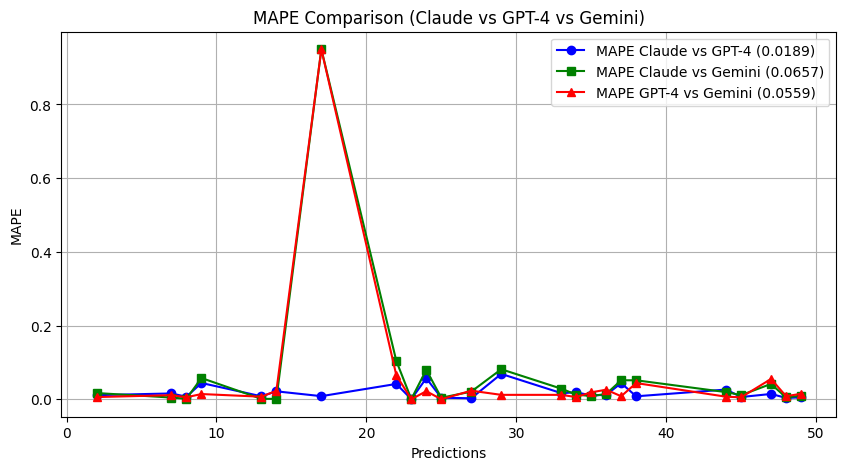

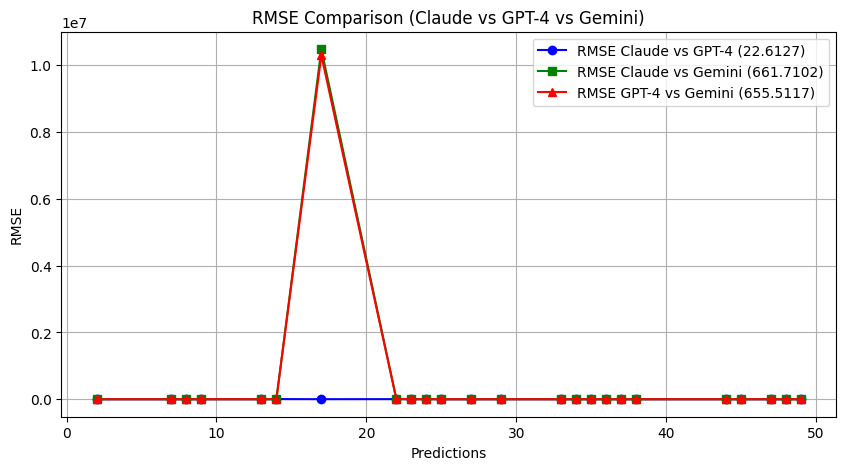

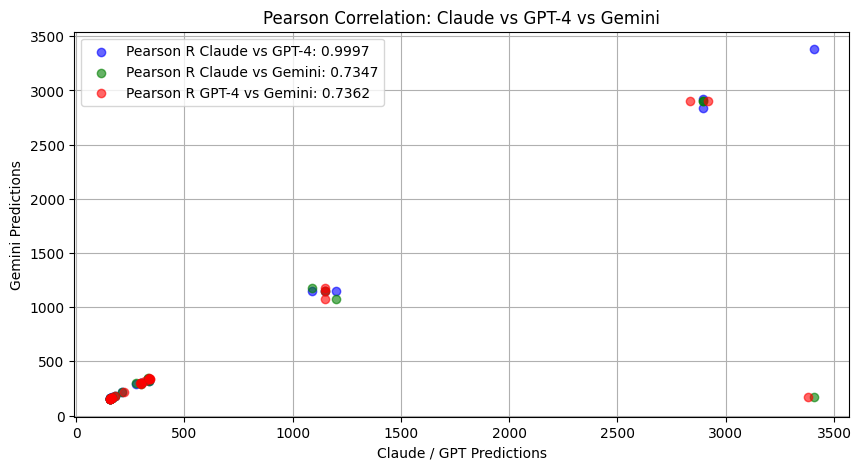


📊 Comparison Results:
🔹 MAPE Claude vs GPT-4: 0.0189
🔹 MAPE Claude vs Gemini: 0.0657
🔹 MAPE GPT-4 vs Gemini: 0.0559

🔹 RMSE Claude vs GPT-4: 22.6127
🔹 RMSE Claude vs Gemini: 661.7102
🔹 RMSE GPT-4 vs Gemini: 655.5117

🔹 Pearson R Claude vs GPT-4: 0.9997
🔹 Pearson R Claude vs Gemini: 0.7347
🔹 Pearson R GPT-4 vs Gemini: 0.7362


In [ ]:

# 🔹 Load numerical prediction CSV files for Claude, GPT-4, and Gemini
df_claude = pd.read_csv("claude_predictions_jan_jun_2022.csv")
df_gpt = pd.read_csv("gpt4_predictions_jan_jun_2022.csv")
df_gemini = pd.read_csv("gemini_predictions_jan_jun_2022.csv")

# 🔹 Merge numerical predictions based on Ticker and Date
df_merged = pd.merge(df_claude, df_gpt, on=["Ticker", "Date"], suffixes=("_claude", "_gpt"))
df_merged = pd.merge(df_merged, df_gemini, on=["Ticker", "Date"])
df_merged.rename(columns={"Predicted Close Price": "Predicted Close Price_gemini"}, inplace=True)

# 🔹 Convert "Predicted Close Price" columns to numeric, handling 'None' and NaN values
df_merged["Predicted Close Price_claude"] = pd.to_numeric(df_merged["Predicted Close Price_claude"], errors='coerce')
df_merged["Predicted Close Price_gpt"] = pd.to_numeric(df_merged["Predicted Close Price_gpt"], errors='coerce')
df_merged["Predicted Close Price_gemini"] = pd.to_numeric(df_merged["Predicted Close Price_gemini"], errors='coerce')

# 🔹 Drop rows where any value is NaN (invalid or missing predictions)
df_filtered = df_merged.dropna(subset=["Predicted Close Price_claude", "Predicted Close Price_gpt", "Predicted Close Price_gemini"])

# ✅ Compute Metrics for Claude vs GPT, Claude vs Gemini, and GPT vs Gemini
mape_claude_gpt = mean_absolute_percentage_error(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gpt"])
mape_claude_gemini = mean_absolute_percentage_error(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gemini"])
mape_gpt_gemini = mean_absolute_percentage_error(df_filtered["Predicted Close Price_gpt"], df_filtered["Predicted Close Price_gemini"])

rmse_claude_gpt = np.sqrt(mean_squared_error(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gpt"]))
rmse_claude_gemini = np.sqrt(mean_squared_error(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gemini"]))
rmse_gpt_gemini = np.sqrt(mean_squared_error(df_filtered["Predicted Close Price_gpt"], df_filtered["Predicted Close Price_gemini"]))

pearson_claude_gpt, _ = pearsonr(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gpt"])
pearson_claude_gemini, _ = pearsonr(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gemini"])
pearson_gpt_gemini, _ = pearsonr(df_filtered["Predicted Close Price_gpt"], df_filtered["Predicted Close Price_gemini"])

# 🔹 Plot MAPE Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, abs(df_filtered["Predicted Close Price_claude"] - df_filtered["Predicted Close Price_gpt"]) / df_filtered["Predicted Close Price_claude"], label=f"MAPE Claude vs GPT-4 ({mape_claude_gpt:.4f})", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, abs(df_filtered["Predicted Close Price_claude"] - df_filtered["Predicted Close Price_gemini"]) / df_filtered["Predicted Close Price_claude"], label=f"MAPE Claude vs Gemini ({mape_claude_gemini:.4f})", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, abs(df_filtered["Predicted Close Price_gpt"] - df_filtered["Predicted Close Price_gemini"]) / df_filtered["Predicted Close Price_gpt"], label=f"MAPE GPT-4 vs Gemini ({mape_gpt_gemini:.4f})", color="red", marker="^", linestyle="-")

plt.xlabel("Predictions")
plt.ylabel("MAPE")
plt.title("MAPE Comparison (Claude vs GPT-4 vs Gemini)")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot RMSE Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, (df_filtered["Predicted Close Price_claude"] - df_filtered["Predicted Close Price_gpt"])**2, label=f"RMSE Claude vs GPT-4 ({rmse_claude_gpt:.4f})", color="blue", marker="o", linestyle="-")
plt.plot(df_filtered.index, (df_filtered["Predicted Close Price_claude"] - df_filtered["Predicted Close Price_gemini"])**2, label=f"RMSE Claude vs Gemini ({rmse_claude_gemini:.4f})", color="green", marker="s", linestyle="-")
plt.plot(df_filtered.index, (df_filtered["Predicted Close Price_gpt"] - df_filtered["Predicted Close Price_gemini"])**2, label=f"RMSE GPT-4 vs Gemini ({rmse_gpt_gemini:.4f})", color="red", marker="^", linestyle="-")

plt.xlabel("Predictions")
plt.ylabel("RMSE")
plt.title("RMSE Comparison (Claude vs GPT-4 vs Gemini)")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot Pearson Correlation for Each Pair
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gpt"], label=f"Pearson R Claude vs GPT-4: {pearson_claude_gpt:.4f}", color="blue", alpha=0.6)
plt.scatter(df_filtered["Predicted Close Price_claude"], df_filtered["Predicted Close Price_gemini"], label=f"Pearson R Claude vs Gemini: {pearson_claude_gemini:.4f}", color="green", alpha=0.6)
plt.scatter(df_filtered["Predicted Close Price_gpt"], df_filtered["Predicted Close Price_gemini"], label=f"Pearson R GPT-4 vs Gemini: {pearson_gpt_gemini:.4f}", color="red", alpha=0.6)

plt.xlabel("Claude / GPT Predictions")
plt.ylabel("Gemini Predictions")
plt.title("Pearson Correlation: Claude vs GPT-4 vs Gemini")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print Results
print(f"\n📊 Comparison Results:")
print(f"🔹 MAPE Claude vs GPT-4: {mape_claude_gpt:.4f}")
print(f"🔹 MAPE Claude vs Gemini: {mape_claude_gemini:.4f}")
print(f"🔹 MAPE GPT-4 vs Gemini: {mape_gpt_gemini:.4f}")

print(f"\n🔹 RMSE Claude vs GPT-4: {rmse_claude_gpt:.4f}")
print(f"🔹 RMSE Claude vs Gemini: {rmse_claude_gemini:.4f}")
print(f"🔹 RMSE GPT-4 vs Gemini: {rmse_gpt_gemini:.4f}")

print(f"\n🔹 Pearson R Claude vs GPT-4: {pearson_claude_gpt:.4f}")
print(f"🔹 Pearson R Claude vs Gemini: {pearson_claude_gemini:.4f}")
print(f"🔹 Pearson R GPT-4 vs Gemini: {pearson_gpt_gemini:.4f}")


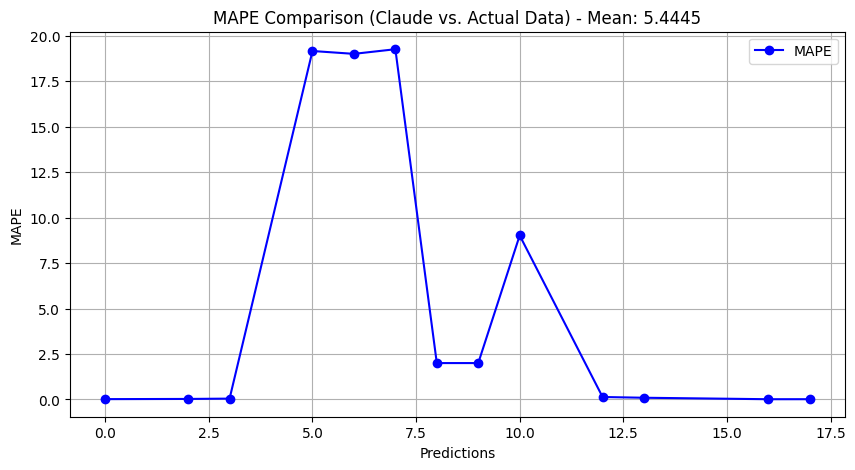

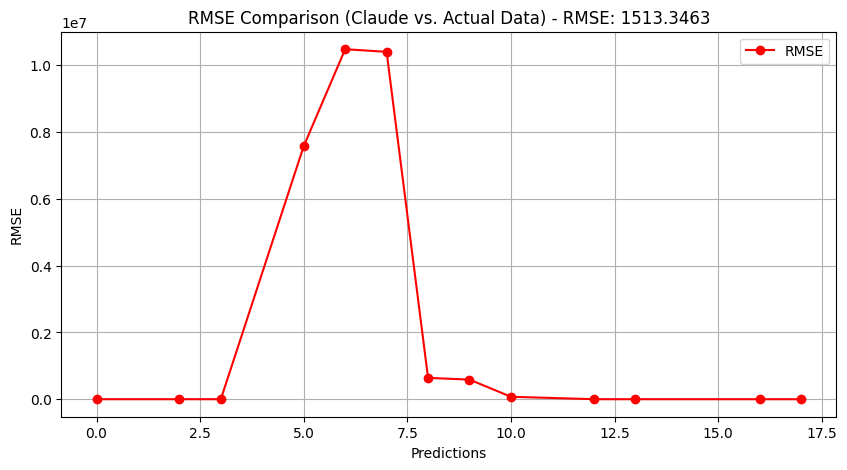

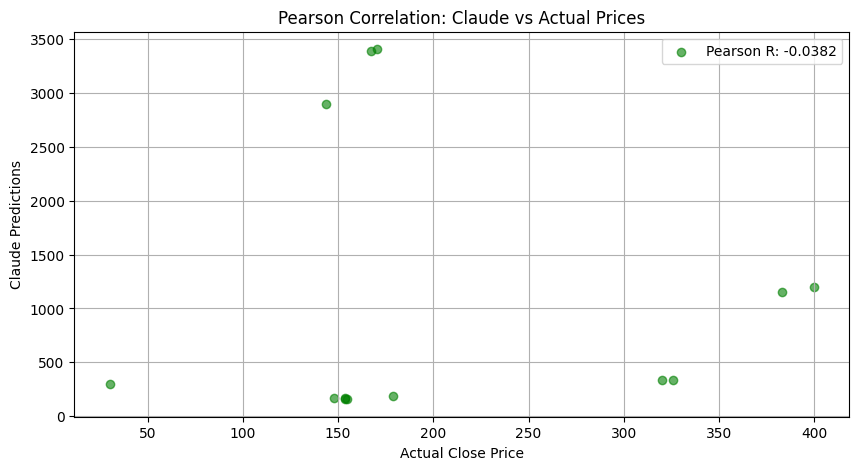


📊 Comparison Results:
🔹 MAPE: 5.4445
🔹 RMSE: 1513.3463
🔹 Pearson R Correlation: -0.0382


In [ ]:


# 🔹 Load the numerical prediction CSV files
df_claude = pd.read_csv("claude_predictions_jan_jun_2022.csv")
df_actual = pd.read_csv("financial_forecasting_cleaned_two.csv")

# 🔹 Standardize column names to match
df_actual.rename(columns={"Adj Close": "Actual Close Price"}, inplace=True)

# 🔹 Convert Date column to datetime format
df_claude["Date"] = pd.to_datetime(df_claude["Date"])
df_actual["Date"] = pd.to_datetime(df_actual["Date"])

# 🔹 Merge numerical predictions based on Ticker and Date
df_merged = pd.merge(df_claude, df_actual, on=["Ticker", "Date"], how="inner")

# 🔹 Convert values to numeric and handle missing values
df_merged["Predicted Close Price"] = pd.to_numeric(df_merged["Predicted Close Price"], errors='coerce')
df_merged["Actual Close Price"] = pd.to_numeric(df_merged["Actual Close Price"], errors='coerce')

# 🔹 Drop rows where either value is NaN (due to 'None' or missing values)
df_filtered = df_merged.dropna(subset=["Predicted Close Price", "Actual Close Price"])

# ✅ Compute Metrics
mape = mean_absolute_percentage_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])
rmse = np.sqrt(mean_squared_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"]))
pearson_r, _ = pearsonr(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])

# 🔹 Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, abs(df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"]) / df_filtered["Actual Close Price"], label="MAPE", color="blue", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("MAPE")
plt.title(f"MAPE Comparison (Claude vs. Actual Data) - Mean: {mape:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, (df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"])**2, label="RMSE", color="red", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("RMSE")
plt.title(f"RMSE Comparison (Claude vs. Actual Data) - RMSE: {rmse:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot Pearson R Correlation
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"], label=f"Pearson R: {pearson_r:.4f}", color="green", alpha=0.6)
plt.xlabel("Actual Close Price")
plt.ylabel("Claude Predictions")
plt.title("Pearson Correlation: Claude vs Actual Prices")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print Results
print(f"\n📊 Comparison Results:")
print(f"🔹 MAPE: {mape:.4f}")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 Pearson R Correlation: {pearson_r:.4f}")

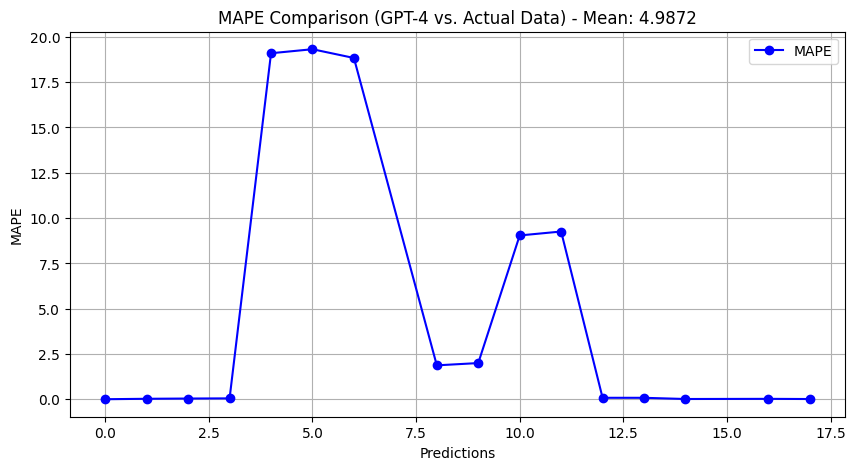

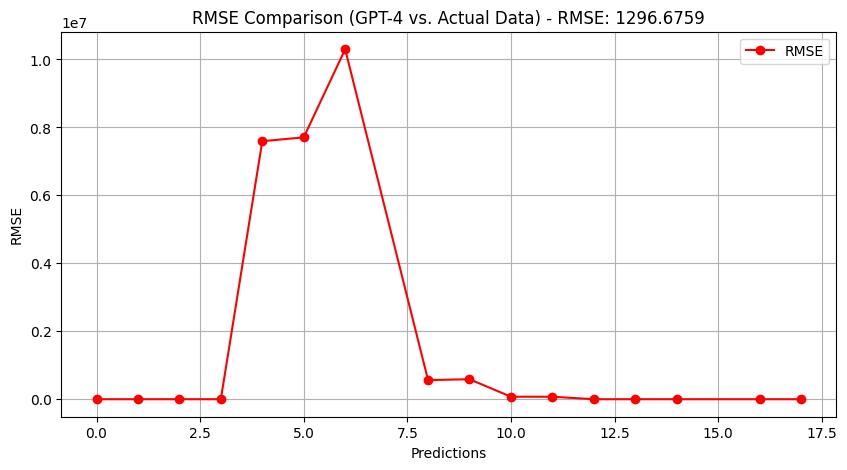

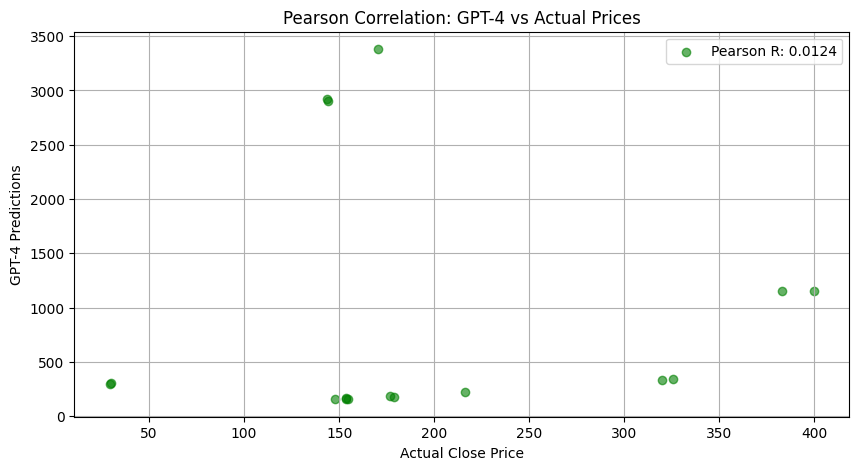


📊 Comparison Results:
🔹 MAPE: 4.9872
🔹 RMSE: 1296.6759
🔹 Pearson R Correlation: 0.0124


In [ ]:
# 🔹 Load the numerical prediction CSV files
df_gpt = pd.read_csv("gpt4_predictions_jan_jun_2022.csv")
df_actual = pd.read_csv("financial_forecasting_cleaned_two.csv")

# 🔹 Standardize column names to match
df_actual.rename(columns={"Adj Close": "Actual Close Price"}, inplace=True)

# 🔹 Convert Date column to datetime format
df_gpt["Date"] = pd.to_datetime(df_gpt["Date"])
df_actual["Date"] = pd.to_datetime(df_actual["Date"])

# 🔹 Merge numerical predictions based on Ticker and Date
df_merged = pd.merge(df_gpt, df_actual, on=["Ticker", "Date"], how="inner")

# 🔹 Convert values to numeric and handle missing values
df_merged["Predicted Close Price"] = pd.to_numeric(df_merged["Predicted Close Price"], errors='coerce')
df_merged["Actual Close Price"] = pd.to_numeric(df_merged["Actual Close Price"], errors='coerce')

# 🔹 Drop rows where either value is NaN (due to 'None' or missing values)
df_filtered = df_merged.dropna(subset=["Predicted Close Price", "Actual Close Price"])

# ✅ Compute Metrics
mape = mean_absolute_percentage_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])
rmse = np.sqrt(mean_squared_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"]))
pearson_r, _ = pearsonr(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])

# 🔹 Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, abs(df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"]) / df_filtered["Actual Close Price"], label="MAPE", color="blue", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("MAPE")
plt.title(f"MAPE Comparison (GPT-4 vs. Actual Data) - Mean: {mape:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, (df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"])**2, label="RMSE", color="red", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("RMSE")
plt.title(f"RMSE Comparison (GPT-4 vs. Actual Data) - RMSE: {rmse:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot Pearson R Correlation
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"], label=f"Pearson R: {pearson_r:.4f}", color="green", alpha=0.6)
plt.xlabel("Actual Close Price")
plt.ylabel("GPT-4 Predictions")
plt.title("Pearson Correlation: GPT-4 vs Actual Prices")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print Results
print(f"\n📊 Comparison Results:")
print(f"🔹 MAPE: {mape:.4f}")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 Pearson R Correlation: {pearson_r:.4f}")

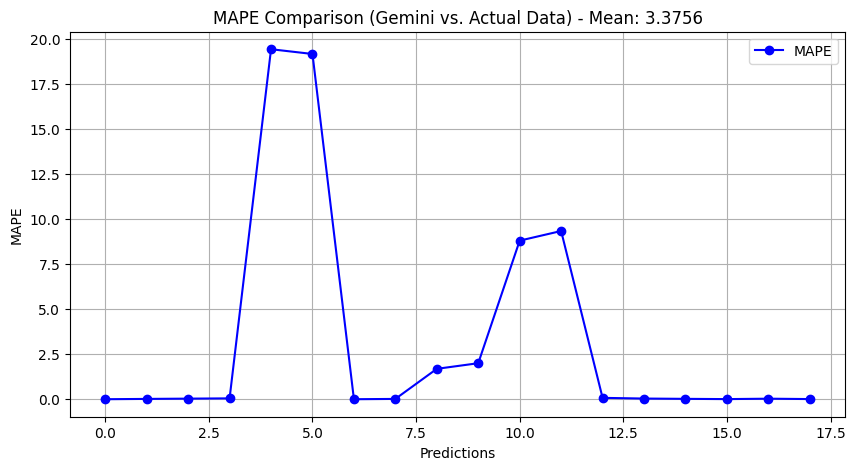

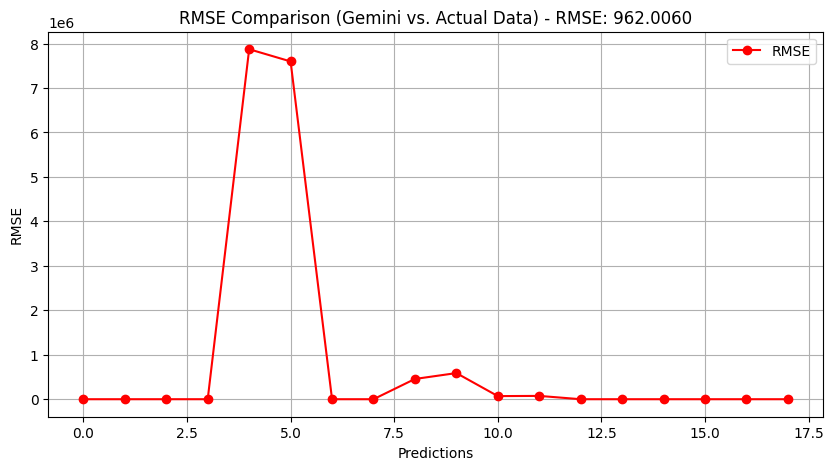

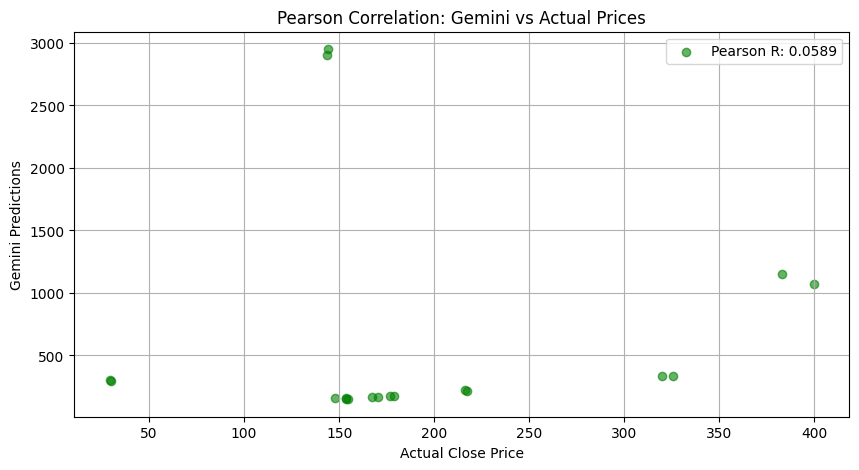


📊 Comparison Results:
🔹 MAPE: 3.3756
🔹 RMSE: 962.0060
🔹 Pearson R Correlation: 0.0589


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import pearsonr

# 🔹 Load the numerical prediction CSV files
df_gemini = pd.read_csv("gemini_predictions_jan_jun_2022.csv")
df_actual = pd.read_csv("financial_forecasting_cleaned_two.csv")

# 🔹 Standardize column names to match
df_actual.rename(columns={"Adj Close": "Actual Close Price"}, inplace=True)

# 🔹 Convert Date column to datetime format
df_gemini["Date"] = pd.to_datetime(df_gemini["Date"])
df_actual["Date"] = pd.to_datetime(df_actual["Date"])

# 🔹 Merge numerical predictions based on Ticker and Date
df_merged = pd.merge(df_gemini, df_actual, on=["Ticker", "Date"], how="inner")

# 🔹 Convert values to numeric and handle missing values
df_merged["Predicted Close Price"] = pd.to_numeric(df_merged["Predicted Close Price"], errors='coerce')
df_merged["Actual Close Price"] = pd.to_numeric(df_merged["Actual Close Price"], errors='coerce')

# 🔹 Drop rows where either value is NaN (due to 'None' or missing values)
df_filtered = df_merged.dropna(subset=["Predicted Close Price", "Actual Close Price"])

# ✅ Compute Metrics
mape = mean_absolute_percentage_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])
rmse = np.sqrt(mean_squared_error(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"]))
pearson_r, _ = pearsonr(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"])

# 🔹 Plot MAPE (Gemini vs Actual)
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, abs(df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"]) / df_filtered["Actual Close Price"], label="MAPE", color="blue", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("MAPE")
plt.title(f"MAPE Comparison (Gemini vs. Actual Data) - Mean: {mape:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot RMSE (Gemini vs Actual)
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, (df_filtered["Actual Close Price"] - df_filtered["Predicted Close Price"])**2, label="RMSE", color="red", marker="o", linestyle="-")
plt.xlabel("Predictions")
plt.ylabel("RMSE")
plt.title(f"RMSE Comparison (Gemini vs. Actual Data) - RMSE: {rmse:.4f}")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot Pearson R Correlation (Gemini vs Actual)
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered["Actual Close Price"], df_filtered["Predicted Close Price"], label=f"Pearson R: {pearson_r:.4f}", color="green", alpha=0.6)
plt.xlabel("Actual Close Price")
plt.ylabel("Gemini Predictions")
plt.title("Pearson Correlation: Gemini vs Actual Prices")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print Results
print(f"\n📊 Comparison Results:")
print(f"🔹 MAPE: {mape:.4f}")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 Pearson R Correlation: {pearson_r:.4f}")


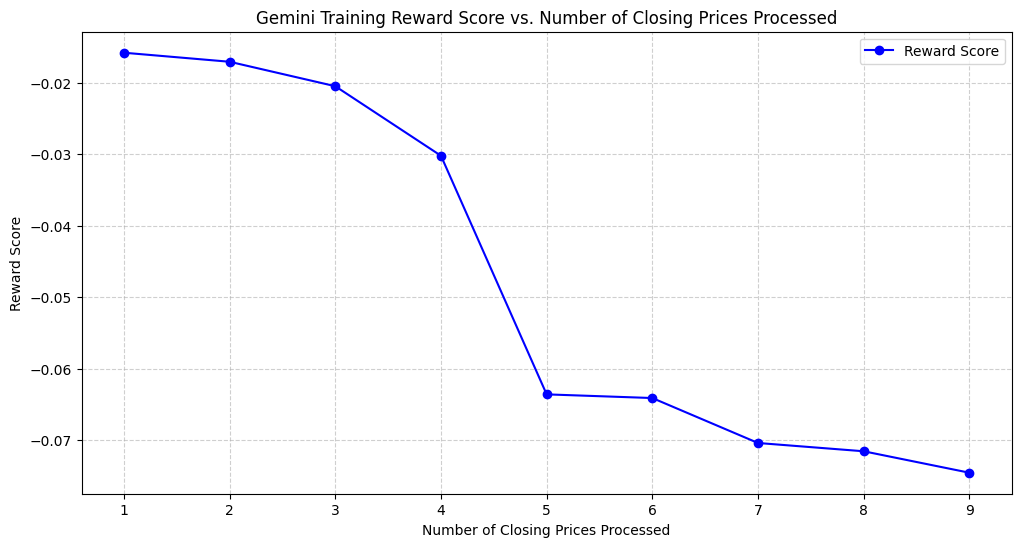

In [ ]:

# 🔹 Load the reward scores CSV
df_rewards = pd.read_csv("gemini_reward_scores_training.csv")

# 🔹 Generate X-axis values (Number of closing prices processed)
num_prices_processed = list(range(1, len(df_rewards) + 1))  # Sequential numbering

# 🔹 Extract Reward Scores
reward_scores = df_rewards["Reward Score"]

# 🔹 Plot the Reward Score Trend
plt.figure(figsize=(12, 6))
plt.plot(num_prices_processed, reward_scores, marker="o", linestyle="-", color="blue", label="Reward Score")

# 🔹 Graph Labels & Customization
plt.xlabel("Number of Closing Prices Processed")
plt.ylabel("Reward Score")
plt.title("Gemini Training Reward Score vs. Number of Closing Prices Processed")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# 📈 Show the plot
plt.show()

Claude Time taken = 499.54876017570496
GPT Time taken = 499.2416663169861
Gemini Time taken = 112.85891962051392


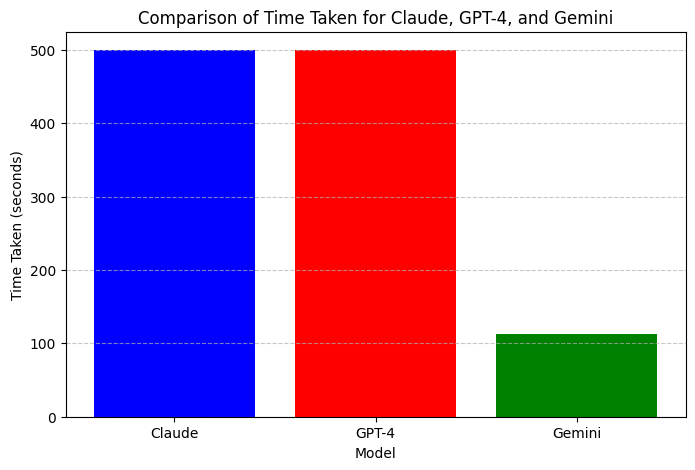

In [ ]:
print("Claude Time taken = " + str(totalClaudetime))
print("GPT Time taken = " + str(totalGPTtime))
print("Gemini Time taken = " + str(totalGeminitime))

models = ["Claude", "GPT-4", "Gemini"]
time_taken = [totalClaudetime, totalGPTtime, totalGeminitime]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, time_taken, color=['blue', 'red', 'green'])

# Labels and title
plt.xlabel("Model")
plt.ylabel("Time Taken (minutes)")
plt.title("Comparison of Time Taken for Claude, GPT-4, and Gemini")

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Claude Accuracy = 0.62
GPT Accuracy = 1.5151515151515151
Gemini Accuracy = 0.98


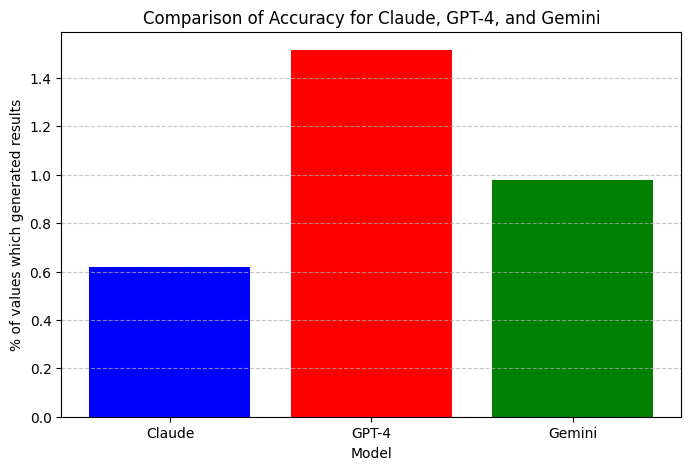

In [ ]:
ClaudeAccuracy=numofactualCValues/numofClaudeValues
GPTAccuracy=numofGPTvalues/numofactualvalues
#LlamaAccuracy=numofactualLvalues/numofLlamaValues
GeminiAccuracy=numofactualGvalues/numofGeminivalues

print("Claude Accuracy = " + str(ClaudeAccuracy))
print("GPT Accuracy = " + str(GPTAccuracy))
print("Gemini Accuracy = " + str(GeminiAccuracy))

models = ["Claude", "GPT-4", "Gemini"]
accuracy = [ClaudeAccuracy,GPTAccuracy,GeminiAccuracy]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy, color=['blue', 'red', 'green'])

# Labels and title
plt.xlabel("Model")
plt.ylabel("% of values which generated results")
plt.title("Comparison of Accuracy for Claude, GPT-4, and Gemini")

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()